Author: Daniel Head

Project: ITSC 5156 Applied Machine Learning Final Project

Project Topic: Email Spam Detection 

Dataset: https://www.kaggle.com/datasets/nitishabharathi/email-spam-dataset?resource=download

First off, I'll import everything I need and will print the versions I have for some of the imports:


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from copy import deepcopy as copy
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
import re
import gc
!pip install num2words
from num2words import num2words
from wordcloud import WordCloud
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
sklearn.__version__

'1.0.2'

In [ ]:
pd.__version__

'1.3.5'

In [ ]:
np.__version__

'1.21.6'

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
tf.test.is_built_with_cuda()

True

In [ ]:
def plot_training(history):
  fig = plt.figure(figsize=(16,12))

  ax1 = fig.add_subplot(221)
  ax1.plot(history.history['accuracy'], c='Blue', label='Accuracy')
  ax1.plot(history.history['val_accuracy'], c='Green', label='Validation Accuracy')
  ax1.set_ylabel('Accuracy')
  ax1.set_xlabel('Epochs')
  ax1.legend()

  ax2 = fig.add_subplot(222)
  ax2.plot(history.history['loss'], c='Blue', label='Loss')
  ax2.plot(history.history['val_loss'], c='Green', label='Validation Loss')
  ax2.set_ylabel('Loss')
  ax2.set_xlabel('Epochs')
  ax2.legend()

# I copied this from our class labs:
turn_off_garbage_collect = False

def garbage_collect(vars_):
    if not turn_off_garbage_collect:
        for v in vars_:
            if v in globals():
                del globals()[v]
        collected = gc.collect()

**Actually, I decided to upload this to Colab, so I will link Google Drive to get the files. You may need to adjust this code if you try to run it yourself.**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


To get started, I'll import the data and create a dataframe to work with. The dataset above includes 3 csv files: completeSpamAssassin, enronSpamSubset, and lingSpam. The important columns are the "body" and "label" columns which contain the body text as well as the label for each message.

In [ ]:
columns = ['Body','Label']

# Read all the files:
df_complete = pd.read_csv('/content/gdrive/My Drive/Colab Data/completeSpamAssassin.csv', usecols=columns)
df_enron = pd.read_csv('/content/gdrive/My Drive/Colab Data/enronSpamSubset.csv', usecols=columns)
df_ling = pd.read_csv('/content/gdrive/My Drive/Colab Data/lingSpam.csv', usecols=columns)

# Combine all the files into a single dataframe:
df = pd.concat([df_complete, df_enron, df_ling], ignore_index=True)
df.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


The dataframe has a fairly large number of records now (more than 18,000), but I suspect some may be duplicates or that there may be nulls and will go ahead and drop those.

In [ ]:
df.shape

(18651, 2)

We still have a large number of records but no more duplicates or null records.

In [ ]:
df = df.dropna().drop_duplicates()
df.shape

(17571, 2)

I'm just curious about a quick look at what text is most common in the body field:

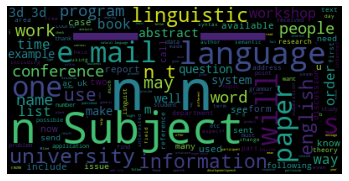

In [ ]:
wordcloud = WordCloud(random_state=1).generate(str(df['Body'].values))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Now, let's split our data into training and test data with the usual 20% split.

In [ ]:
X = df['Body']
X.shape

(17571,)

In [ ]:
T = df['Label']
T.shape

(17571,)

In [ ]:
X_train, X_test, t_train, t_test = train_test_split(X, T, test_size=0.2, random_state=0)
print(f'Train data shape: {X_train.shape}')
print(f'Train target shape: {t_train.shape}')
print(f'Test data shape: {X_test.shape}')
print(f'Test target shape: {t_test.shape}')

Train data shape: (14056,)
Train target shape: (14056,)
Test data shape: (3515,)
Test target shape: (3515,)


Now, let's begin getting ready for the models we want to train.

In [ ]:
num_words = 50000
max_length = 400

tokenizer = Tokenizer(num_words=num_words,lower=True,split=' ',oov_token=None)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length)

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length)

In [ ]:
X_train_padded

array([[    0,     0,     0, ...,   710,  2566, 15188],
       [    0,     0,     0, ...,     3,   394,  2063],
       [    0,     0,     0, ...,   233,   418,    75],
       ...,
       [    0,     0,     0, ...,    27,   360,  1162],
       [    0,     0,     0, ...,  1338, 21565,  1499],
       [    0,     0,     0, ...,   233,   320,  5563]], dtype=int32)

In [ ]:
X_train_padded.shape

(14056, 400)

Now, we can use the tokenized and padded data for the model.

I will attempt to replicate what was done in the primary work I chose (Phish Responder: A Hybrid Machine Learning Approach to Detect Phishing and Spam Emails). The layers come from the paper, and they used binary_crossentropy because of research suggesting it was the best option. In their testing, they found nadam to be the best optimizer.

When I tried to create this, I found that LSTM expects more dimensions than I had. I found a stack overflow post which helped to resolve the issue: https://stackoverflow.com/questions/58119320/valueerror-input-0-of-layer-lstm-is-incompatible-with-the-layer-expected-ndim

In [ ]:
X_train_padded = np.expand_dims(X_train_padded, 1)
X_test_padded = np.expand_dims(X_test_padded, 1)
X_train_padded.shape

(14056, 1, 400)

In [ ]:
X_train_padded.shape[1:]

(1, 400)

In [ ]:
X_train_padded.shape[0]

14056

Also, let's save checkpoints for the model during/after training - Colab disconnects me often so I think this will be good to have. Example from: https://www.tensorflow.org/tutorials/keras/save_and_load

In [ ]:
checkpoint_path = 'gdrive/My Drive/Colab Data/training_1/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

In [ ]:
model = keras.Sequential(
    [
        layers.LSTM(200, input_shape=(X_train_padded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.LSTM(10, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(4, activation='sigmoid', name='layer5'),
        layers.Dense(3, activation='sigmoid', name='layer6'),
        layers.Dense(2, activation='sigmoid', name='layer7'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

opt = tf.keras.optimizers.Nadam(learning_rate=0.2)

model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

model.build(input_shape=X_train_padded.shape)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 200)            480800    
                                                                 
 layer1 (Dense)              (None, 1, 60)             12060     
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 layer5 (Dense)              (None, 4)                 24        
                                                                 
 layer6 (Dense)              (None, 3)                

Now, let's start to train our model. The paper I chose said they found that 100 epochs was optimal, as well as a batch size of 32. 

I ran this with 100 originally, but it wasn't very promising. I've lowered it to 25 just to show where it's at like this.

In [ ]:
n_epochs = 25
batch_size = 32

In [ ]:
history = model.fit(X_train_padded, t_train, epochs=n_epochs, batch_size=batch_size, 
                    validation_split=0.1, verbose=1, callbacks=[cp_callback])

Epoch 1/25
393/396 [============================>.] - ETA: 0s - loss: 0.6635 - accuracy: 0.6273
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_1/cp.ckpt
396/396 [==============================] - 9s 13ms/step - loss: 0.6636 - accuracy: 0.6271 - val_loss: 0.6667 - val_accuracy: 0.6358
Epoch 2/25
393/396 [============================>.] - ETA: 0s - loss: 0.6618 - accuracy: 0.6268
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_1/cp.ckpt
396/396 [==============================] - 5s 13ms/step - loss: 0.6619 - accuracy: 0.6265 - val_loss: 0.6713 - val_accuracy: 0.6358
Epoch 3/25
393/396 [============================>.] - ETA: 0s - loss: 0.6640 - accuracy: 0.6279
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_1/cp.ckpt
396/396 [==============================] - 5s 12ms/step - loss: 0.6637 - accuracy: 0.6284 - val_loss: 0.6666 - val_accuracy: 0.6358
Epoch 4/25
394/396 [============================>.] - ETA: 0s - loss: 0.6627 - accuracy: 0.6284
Epoch 4

In [ ]:
results = model.evaluate(X_test_padded, t_test, batch_size=batch_size)


110/110 [==============================] - 0s 4ms/step - loss: 0.6659 - accuracy: 0.6165


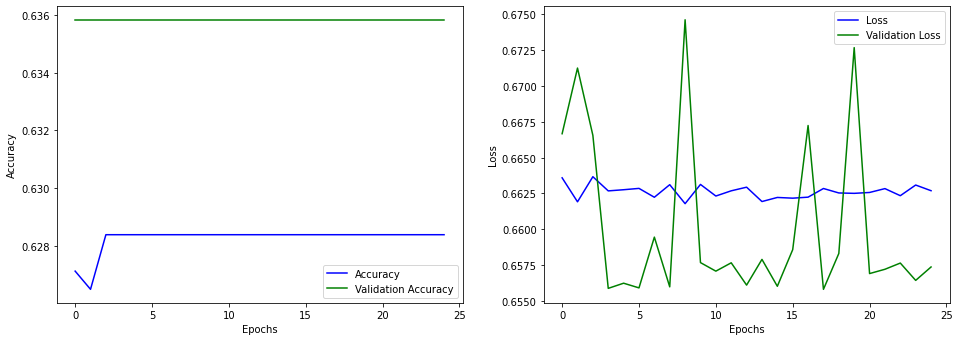

In [ ]:
plot_training(history)

In [ ]:
model.save('gdrive/My Drive/Colab Data/training_1/model')

In [ ]:
garbage_collect([
    'X_train','X_test','t_train','t_test','X_train_padded','X_test_padded','history','model','X','T'
])

For the next part, I decided to reduce the amount of data I was using. I was getting messages about RAM being full, so thought that using less would be good. This set alone is around 5,000 records.

Well, that doesn't look very promising. I thought that tokenizing (and padding) the data may give good results but it seems that's not enough. Let's try using NLTK to remove stop words and then removing puncutation before tokenizing it. The first entry looks like this currently:

In [ ]:
df_complete = df_complete.dropna().drop_duplicates()
df_complete.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


In [ ]:
X = df_complete['Body']
T = df_complete['Label']
X = X.astype(str)

In [ ]:
X[0]

"\nSave up to 70% on Life Insurance.\nWhy Spend More Than You Have To?Life Quote Savings\nEnsuring your \n      family's financial security is very important. Life Quote Savings makes \n      buying life insurance simple and affordable. We Provide FREE Access to The \n      Very Best Companies and The Lowest Rates.Life Quote Savings is FAST, EASY and \n            SAVES you money! Let us help you get started with the best values in \n            the country on new coverage. You can SAVE hundreds or even thousands \n            of dollars by requesting a FREE quote from Lifequote Savings. Our \n            service will take you less than 5 minutes to complete. Shop and \n            compare. SAVE up to 70% on all types of Life insurance! Click Here For Your \n            Free Quote!Protecting your family is the best investment you'll ever \n          make!\nIf you are in receipt of this email \n      in error and/or wish to be removed from our list, PLEASE CLICK HERE AND TYPE REMOVE. If

I used the solution here to help with removing the stop words: https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe

My original implementation accidentally created a column for each stop word and it being removed, which I obviously didn't want. This is much better.

In [ ]:
X_clean = X.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
X_clean.head()

0    Save 70% Life Insurance. Why Spend More Than Y...
1    1) Fight The Risk Cancer! http://www.adclick.w...
2    1) Fight The Risk Cancer! http://www.adclick.w...
3    ##############################################...
4    I thought might like these: 1) Slim Down - Gua...
Name: Body, dtype: object

Now, let's take a look at our first entry:

In [ ]:
X_clean[0]

"Save 70% Life Insurance. Why Spend More Than You Have To?Life Quote Savings Ensuring family's financial security important. Life Quote Savings makes buying life insurance simple affordable. We Provide FREE Access The Very Best Companies The Lowest Rates.Life Quote Savings FAST, EASY SAVES money! Let us help get started best values country new coverage. You SAVE hundreds even thousands dollars requesting FREE quote Lifequote Savings. Our service take less 5 minutes complete. Shop compare. SAVE 70% types Life insurance! Click Here For Your Free Quote!Protecting family best investment ever make! If receipt email error and/or wish removed list, PLEASE CLICK HERE AND TYPE REMOVE. If reside state prohibits e-mail solicitations insurance, please disregard email."

Let's also use regular expressions to remove punctuation.

In [ ]:
X_clean = X_clean.apply(lambda x: ' '.join(re.findall('\w+', x)))
X_clean.head()

0    Save 70 Life Insurance Why Spend More Than You...
1    1 Fight The Risk Cancer http www adclick ws p ...
2    1 Fight The Risk Cancer http www adclick ws p ...
3    Adult Club Offers FREE Membership INSTANT ACCE...
4    I thought might like these 1 Slim Down Guarant...
Name: Body, dtype: object

In [ ]:
def can_be_num(string):
  try:
    float(string)
  except:
    return False
  if float(string) == float('inf') or float(string) == float('-inf'):
    return False
  return True

In [ ]:
X_clean = X_clean.apply(lambda x: ' '.join([num2words(float(word)) if can_be_num(word) else word.lower() for word in x.split() ]))
X_clean.head()

0    save seventy life insurance why spend more tha...
1    one fight the risk cancer http www adclick ws ...
2    one fight the risk cancer http www adclick ws ...
3    adult club offers free membership instant acce...
4    i thought might like these one slim down guara...
Name: Body, dtype: object

In [ ]:
X_clean[0]

'save seventy life insurance why spend more than you have to life quote savings ensuring family s financial security important life quote savings makes buying life insurance simple affordable we provide free access the very best companies the lowest rates life quote savings fast easy saves money let us help get started best values country new coverage you save hundreds even thousands dollars requesting free quote lifequote savings our service take less five minutes complete shop compare save seventy types life insurance click here for your free quote protecting family best investment ever make if receipt email error and or wish removed list please click here and type remove if reside state prohibits e mail solicitations insurance please disregard email'

In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_clean)
X_tfidf = pd.DataFrame(X_tfidf.toarray())

In [ ]:
X_tfidf.shape

(5293, 66017)

In [ ]:
#X_tfidf = SelectKBest(chi2, k=500).fit_transform(X_tfidf, T)
#X_tfidf.shape

In [ ]:
X_train_tfidf, X_test_tfidf, t_train_tfidf, t_test_tfidf = train_test_split(X_tfidf, T, test_size=0.2, random_state=0)
print(f'Train data shape: {X_train_tfidf.shape}')
print(f'Train target shape: {t_train_tfidf.shape}')
print(f'Test data shape: {X_test_tfidf.shape}')
print(f'Test target shape: {t_test_tfidf.shape}')

Train data shape: (4234, 66017)
Train target shape: (4234,)
Test data shape: (1059, 66017)
Test target shape: (1059,)


In [ ]:
checkpoint_path = 'gdrive/My Drive/Colab Data/training_2/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

In [ ]:
X_train_tfidf_expanded = np.expand_dims(X_train_tfidf, 1)
X_test_tfidf_expanded = np.expand_dims(X_test_tfidf, 1)

In [ ]:
model = keras.Sequential(
    [
        layers.LSTM(100, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.LSTM(10, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(4, activation='sigmoid', name='layer5'),
        layers.Dense(3, activation='sigmoid', name='layer6'),
        layers.Dense(2, activation='sigmoid', name='layer7'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

opt = tf.keras.optimizers.Nadam(learning_rate=0.2)

model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

model.build(input_shape=X_train_tfidf_expanded.shape)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 100)            26447200  
                                                                 
 layer1 (Dense)              (None, 1, 60)             6060      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 layer5 (Dense)              (None, 4)                 24        
                                                                 
 layer6 (Dense)              (None, 3)                

Now, let's start to train this model.

In [ ]:
n_epochs = 25
batch_size = 32

In [ ]:
history = model.fit(X_train_tfidf_expanded, t_train_tfidf, epochs=n_epochs, batch_size=batch_size, 
                    validation_split=0.1, verbose=1, callbacks=[cp_callback])

Epoch 1/25
118/120 [============================>.] - ETA: 0s - loss: 0.5802 - accuracy: 0.7349
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_2/cp.ckpt
120/120 [==============================] - 7s 30ms/step - loss: 0.5805 - accuracy: 0.7346 - val_loss: 0.6120 - val_accuracy: 0.7476
Epoch 2/25
120/120 [==============================] - ETA: 0s - loss: 0.5782 - accuracy: 0.7388
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_2/cp.ckpt
120/120 [==============================] - 3s 26ms/step - loss: 0.5782 - accuracy: 0.7388 - val_loss: 0.6303 - val_accuracy: 0.7476
Epoch 3/25
119/120 [============================>.] - ETA: 0s - loss: 0.5776 - accuracy: 0.7387
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_2/cp.ckpt
120/120 [==============================] - 3s 24ms/step - loss: 0.5775 - accuracy: 0.7388 - val_loss: 0.5693 - val_accuracy: 0.7476
Epoch 4/25
119/120 [============================>.] - ETA: 0s - loss: 0.5787 - accuracy: 0.7387
Epoch 4

In [ ]:
results = model.evaluate(X_test_tfidf_expanded, t_test_tfidf, batch_size=batch_size)

34/34 [==============================] - 0s 6ms/step - loss: 0.5815 - accuracy: 0.7394


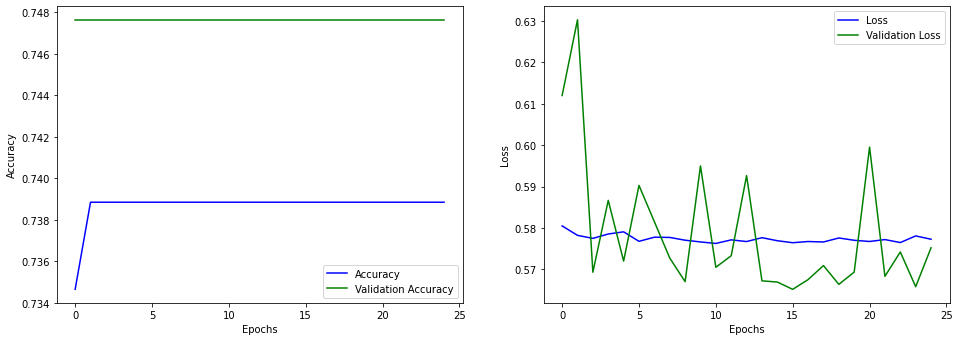

In [ ]:
plot_training(history)

In [ ]:
model.save('gdrive/My Drive/Colab Data/training_2/model')

In [ ]:
garbage_collect([
    'model','history'
])

Well, that isn't much better but it's a slight improvement. Let's try 5 slightly different models and see if any of them perform better.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 200)            52974400  
                                                                 
 layer1 (Dense)              (None, 1, 60)             12060     
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 layer5 (Dense)              (None, 4)                 24        
                                                                 
 layer6 (Dense)              (None, 3)                

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 layer5 (Dense)              (None, 4)                 24        
                                                                 
 layer6 (Dense)              (None, 3)                

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer3 (LSTM)               (None, 60)                29040     
                                                                 
 layer4 (Dense)              (None, 10)                610       
                                                                 
 layer5 (Dense)              (None, 8)                 88        
                                                                 
 layer6 (Dense)              (None, 6)                

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 layer5 (Dense)              (None, 4)                 24        
                                                                 
 layer6 (Dense)              (None, 3)                

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 5)              1320460   
                                                                 
 layer1 (Dense)              (None, 1, 5)              30        
                                                                 
 layer2 (Dense)              (None, 1, 5)              30        
                                                                 
 layer3 (LSTM)               (None, 5)                 220       
                                                                 
 layer4 (Dense)              (None, 5)                 30        
                                                                 
 layer5 (Dense)              (None, 5)                 30        
                                                                 
 layer6 (Dense)              (None, 4)                

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 1, 50)             3300900   
                                                                 
 layer1 (Dense)              (None, 1, 50)             2550      
                                                                 
 layer2 (Dense)              (None, 1, 50)             2550      
                                                                 
 layer3 (Dense)              (None, 1, 50)             2550      
                                                                 
 layer4 (Dense)              (None, 1, 50)             2550      
                                                                 
 layer5 (Dense)              (None, 1, 50)             2550      
                                                                 
 dropout_2 (Dropout)         (None, 1, 50)           

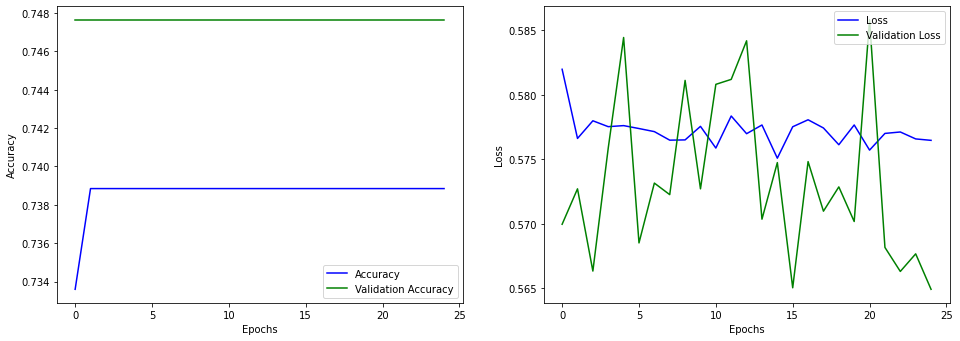

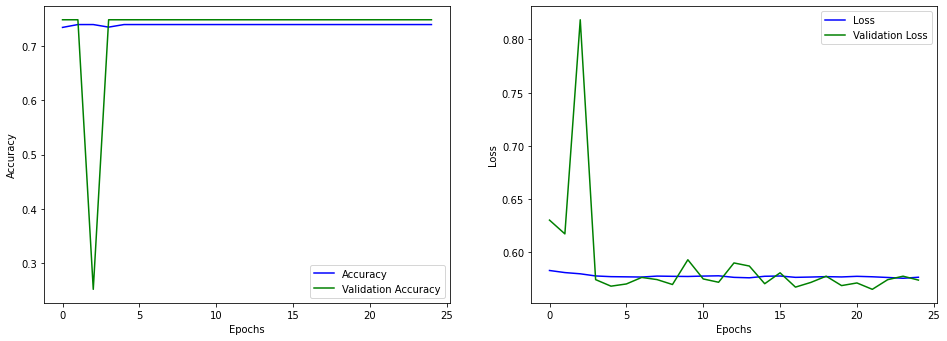

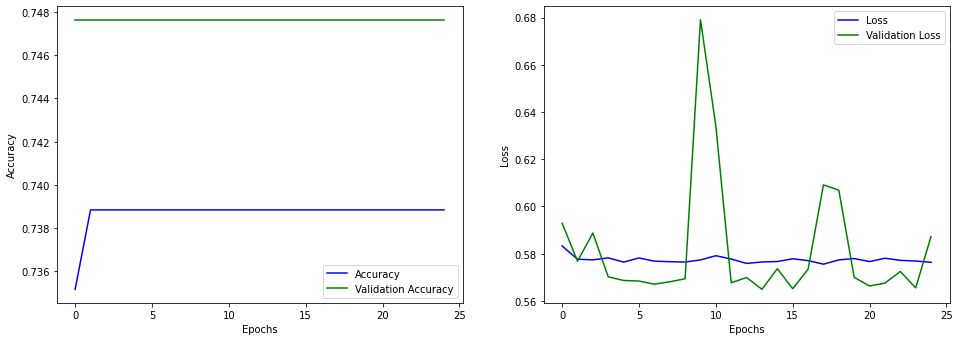

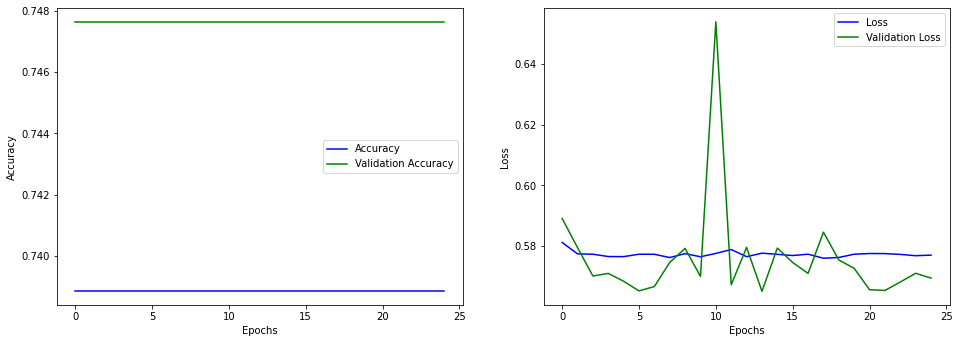

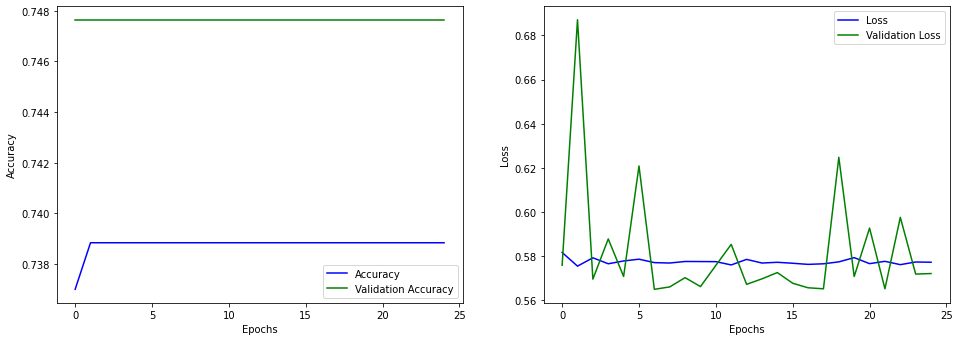

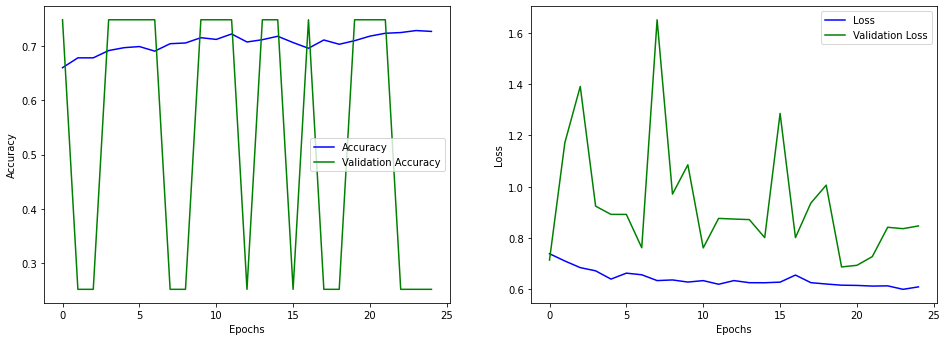

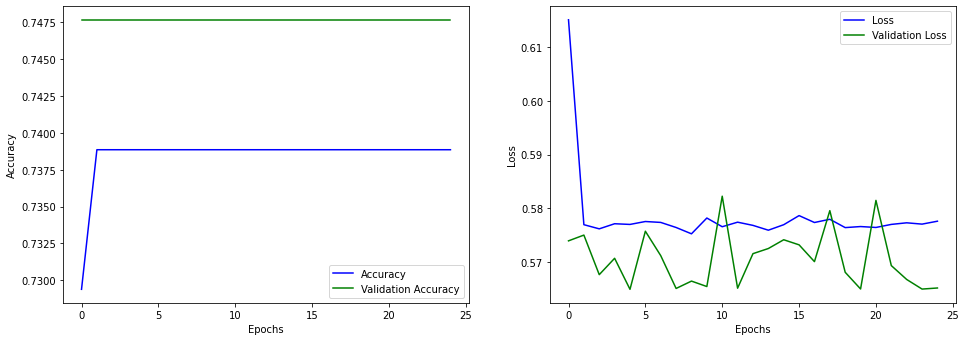

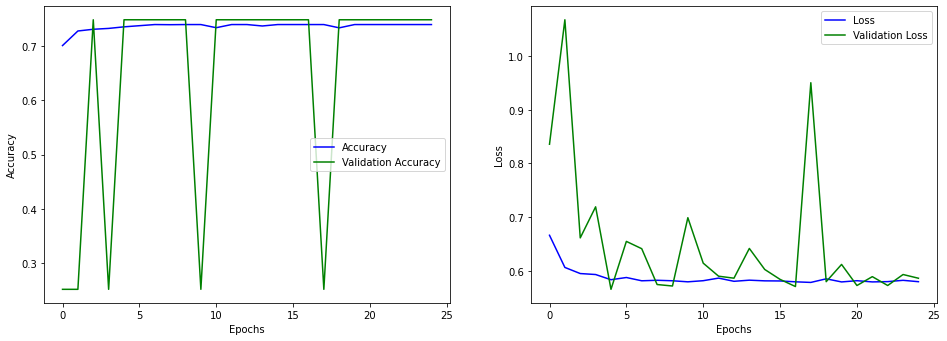

In [ ]:
model_1 = keras.Sequential(
    [
        layers.LSTM(200, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.LSTM(10, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(4, activation='sigmoid', name='layer5'),
        layers.Dense(3, activation='sigmoid', name='layer6'),
        layers.Dense(2, activation='sigmoid', name='layer7'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

model_2 = keras.Sequential(
    [
        layers.LSTM(60, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.LSTM(10, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(4, activation='sigmoid', name='layer5'),
        layers.Dense(3, activation='sigmoid', name='layer6'),
        layers.Dense(2, activation='sigmoid', name='layer7'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

model_3 = keras.Sequential(
    [
        layers.LSTM(60, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(60, activation='sigmoid', name='layer2'),
        layers.LSTM(60, activation='sigmoid', name='layer3'),
        layers.Dense(10, activation='sigmoid', name='layer4'),
        layers.Dense(8, activation='sigmoid', name='layer5'),
        layers.Dense(6, activation='sigmoid', name='layer6'),
        layers.Dense(4, activation='sigmoid', name='layer7'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

model_4 = keras.Sequential(
    [
        layers.LSTM(60, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.LSTM(10, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(4, activation='sigmoid', name='layer5'),
        layers.Dense(3, activation='sigmoid', name='layer6'),
        layers.Dense(2, activation='sigmoid', name='layer7'),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

model_5 = keras.Sequential(
    [
        layers.LSTM(5, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(5, activation='relu', name='layer1'),
        layers.Dense(5, activation='sigmoid', name='layer2'),
        layers.LSTM(5, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(5, activation='sigmoid', name='layer5'),
        layers.Dense(4, activation='sigmoid', name='layer6'),
        layers.Dense(3, activation='sigmoid', name='layer7'),
        layers.Dense(2, activation='sigmoid', name='layer8'),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

model_6 = keras.Sequential(
    [
        layers.Dense(50, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input'),
        layers.Dense(50, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.Dense(50, activation='sigmoid', name='layer3'),
        layers.Dense(50, activation='sigmoid', name='layer4'),
        layers.Dense(50, activation='sigmoid', name='layer5'),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

model_7 = keras.Sequential(
    [
        layers.Dense(50, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input'),
        layers.Dense(50, activation='relu', name='layer1'),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.Dense(50, activation='sigmoid', name='layer3'),
        layers.Dense(50, activation='sigmoid', name='layer4'),
        layers.Dense(50, activation='sigmoid', name='layer5'),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

model_8 = keras.Sequential(
    [
        layers.Dense(50, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input'),
        layers.Dense(50, activation='relu', name='layer1'),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.Dense(50, activation='sigmoid', name='layer3'),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(50, activation='sigmoid', name='layer4'),
        layers.Dense(50, activation='sigmoid', name='layer5'),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8]
histories = []
results_all = []
n_epochs = 25
batch_size = 32

for model in models:
  checkpoint_path = f'gdrive/My Drive/Colab Data/training_{int(models.index(model))+3}/cp.ckpt'
  checkpoint_dir = os.path.dirname(checkpoint_path)
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

  opt = tf.keras.optimizers.Nadam(learning_rate=0.2)

  model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

  model.build(input_shape=X_train_tfidf_expanded.shape)

  print(model.summary())
  history = model.fit(X_train_tfidf_expanded, t_train_tfidf, epochs=n_epochs, batch_size=batch_size, 
                    validation_split=0.1, verbose=1, callbacks=[cp_callback])
  results = model.evaluate(X_test_tfidf_expanded, t_test_tfidf, batch_size=batch_size)
  print(results)
  histories.append(history)
  results_all.append(results)
  plot_training(history)
  
  model.save(f'gdrive/My Drive/Colab Data/training_{int(models.index(model))+3}/model')

In [ ]:
df_complete = df_complete.dropna().drop_duplicates()
df_complete.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


In [ ]:
X = df_complete['Body']
T = df_complete['Label']
X = X.astype(str)

In [ ]:
X[0]

"\nSave up to 70% on Life Insurance.\nWhy Spend More Than You Have To?Life Quote Savings\nEnsuring your \n      family's financial security is very important. Life Quote Savings makes \n      buying life insurance simple and affordable. We Provide FREE Access to The \n      Very Best Companies and The Lowest Rates.Life Quote Savings is FAST, EASY and \n            SAVES you money! Let us help you get started with the best values in \n            the country on new coverage. You can SAVE hundreds or even thousands \n            of dollars by requesting a FREE quote from Lifequote Savings. Our \n            service will take you less than 5 minutes to complete. Shop and \n            compare. SAVE up to 70% on all types of Life insurance! Click Here For Your \n            Free Quote!Protecting your family is the best investment you'll ever \n          make!\nIf you are in receipt of this email \n      in error and/or wish to be removed from our list, PLEASE CLICK HERE AND TYPE REMOVE. If

In [ ]:
X_clean = X.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
X_clean = X_clean.apply(lambda x: ' '.join(re.findall('\w+', x)))
X_clean = X_clean.apply(lambda x: ' '.join([num2words(float(word)) if can_be_num(word) else word.lower() for word in x.split() ]))
X_clean.head()

0    save seventy life insurance why spend more tha...
1    one fight the risk cancer http www adclick ws ...
2    one fight the risk cancer http www adclick ws ...
3    adult club offers free membership instant acce...
4    i thought might like these one slim down guara...
Name: Body, dtype: object

In [ ]:
X_clean[0]

'save seventy life insurance why spend more than you have to life quote savings ensuring family s financial security important life quote savings makes buying life insurance simple affordable we provide free access the very best companies the lowest rates life quote savings fast easy saves money let us help get started best values country new coverage you save hundreds even thousands dollars requesting free quote lifequote savings our service take less five minutes complete shop compare save seventy types life insurance click here for your free quote protecting family best investment ever make if receipt email error and or wish removed list please click here and type remove if reside state prohibits e mail solicitations insurance please disregard email'

In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_clean)
X_tfidf = pd.DataFrame(X_tfidf.toarray())

In [ ]:
X_tfidf.shape

(5293, 66017)

In [ ]:
X_train_tfidf, X_test_tfidf, t_train_tfidf, t_test_tfidf = train_test_split(X_tfidf, T, test_size=0.2, random_state=0)
print(f'Train data shape: {X_train_tfidf.shape}')
print(f'Train target shape: {t_train_tfidf.shape}')
print(f'Test data shape: {X_test_tfidf.shape}')
print(f'Test target shape: {t_test_tfidf.shape}')

Train data shape: (4234, 66017)
Train target shape: (4234,)
Test data shape: (1059, 66017)
Test target shape: (1059,)


In [ ]:
# From our in-class labs: 

def evaluation_report(model, data, verbose=True):
    """
       evaluation report
           create a classification evaluation using accuracy

           parameters
           -----------
           model      trained classifier instance
           data       tuple of (X_train, X_test, t_train, t_test)
           verbose    Set to false to disable printing
    """
   
    X_train, X_test, t_train, t_test = data
    
    train_score = model.score(X_train, t_train)
    test_score = model.score(X_test, t_test)
    if verbose:
        print("{}\n===========================\n".format(model.__class__.__name__))
        print(f"Train Accuracy: {train_score}\nTest Accuracy: {test_score}\n")
    return train_score, test_score

In [ ]:
plt.close('all')

In [ ]:
X_train_tfidf_expanded = np.expand_dims(X_train_tfidf, 1)
X_test_tfidf_expanded = np.expand_dims(X_test_tfidf, 1)

In [ ]:
sgd = SGDClassifier()
perceptron = Perceptron()
nb = GaussianNB()
rcf = RandomForestClassifier()
rcf2 = RandomForestClassifier(max_depth=5)
rcf3 = RandomForestClassifier(max_depth=10)
rcf4 = RandomForestClassifier(max_depth=20)
rcf10 = RandomForestClassifier(max_depth=30)
rcf5 = RandomForestClassifier(max_leaf_nodes=32)
rcf6 = RandomForestClassifier(max_leaf_nodes=128)
rcf7 = RandomForestClassifier(max_leaf_nodes=256)
rcf8 = RandomForestClassifier(max_leaf_nodes=512)
rcf9 = RandomForestClassifier(max_leaf_nodes=1024)

models = [sgd, perceptron, nb, rcf, rcf2, rcf3, rcf4, rcf5, rcf6, rcf7, rcf8, rcf9, rcf10]
scores = []

for model in models:
  model.fit(X_train_tfidf, t_train_tfidf)

  train_score, test_score = evaluation_report(model, (X_train_tfidf, X_test_tfidf, t_train_tfidf, t_test_tfidf))
  scores.append((train_score, test_score))

  pred = model.predict(X_test_tfidf)
  report = classification_report(t_test_tfidf, pred)
  print(report)

SGDClassifier

Train Accuracy: 0.999763816721776
Test Accuracy: 0.9782813975448537

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       783
           1       0.99      0.93      0.96       276

    accuracy                           0.98      1059
   macro avg       0.98      0.96      0.97      1059
weighted avg       0.98      0.98      0.98      1059

Perceptron

Train Accuracy: 0.9995276334435522
Test Accuracy: 0.9792256846081209

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       783
           1       0.97      0.95      0.96       276

    accuracy                           0.98      1059
   macro avg       0.98      0.97      0.97      1059
weighted avg       0.98      0.98      0.98      1059

GaussianNB

Train Accuracy: 0.9985829003306566
Test Accuracy: 0.9291784702549575

              precision    recall  f1-score   support

           0       0.91      1.00      0.95

In [ ]:
model = keras.Sequential(
    [
        layers.LSTM(60, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.LSTM(10, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

#opt = tf.keras.optimizers.Nadam(learning_rate=0.2)

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

model.build(input_shape=X_train_tfidf_expanded.shape)

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

In [ ]:
n_epochs = 25
batch_size = 32

In [ ]:
history = model.fit(X_train_tfidf_expanded, t_train_tfidf, epochs=n_epochs, batch_size=batch_size, 
                    validation_split=0.1, verbose=1)

Epoch 1/25
120/120 [==============================] - 5s 17ms/step - loss: 0.6713 - accuracy: 0.5727 - val_loss: 0.5893 - val_accuracy: 0.7476
Epoch 2/25
120/120 [==============================] - 2s 13ms/step - loss: 0.5179 - accuracy: 0.7388 - val_loss: 0.4324 - val_accuracy: 0.7476
Epoch 3/25
120/120 [==============================] - 1s 12ms/step - loss: 0.3735 - accuracy: 0.8916 - val_loss: 0.3312 - val_accuracy: 0.9835
Epoch 4/25
120/120 [==============================] - 1s 12ms/step - loss: 0.2866 - accuracy: 0.9995 - val_loss: 0.2604 - val_accuracy: 0.9835
Epoch 5/25
120/120 [==============================] - 1s 11ms/step - loss: 0.2259 - accuracy: 0.9997 - val_loss: 0.2047 - val_accuracy: 0.9953
Epoch 6/25
120/120 [==============================] - 1s 11ms/step - loss: 0.1791 - accuracy: 1.0000 - val_loss: 0.1658 - val_accuracy: 0.9953
Epoch 7/25
120/120 [==============================] - 1s 12ms/step - loss: 0.1437 - accuracy: 1.0000 - val_loss: 0.1360 - val_accuracy: 0.9953

In [ ]:
results = model.evaluate(X_test_tfidf_expanded, t_test_tfidf, batch_size=batch_size)
results

34/34 [==============================] - 0s 6ms/step - loss: 0.0563 - accuracy: 0.9877


[0.056261930614709854, 0.987724244594574]

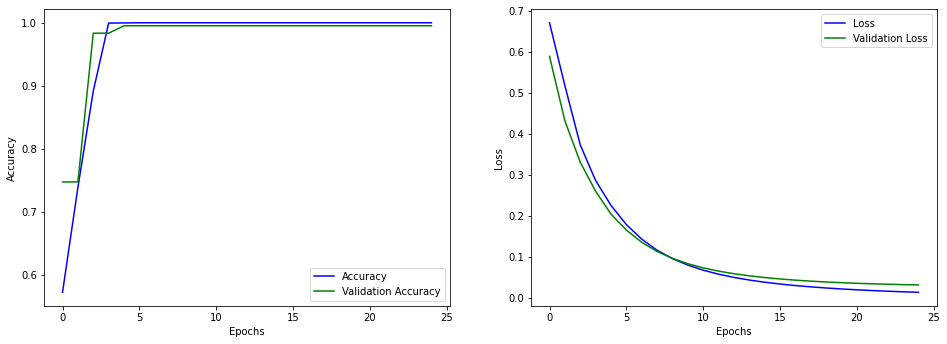

In [ ]:
plot_training(history)

In [ ]:
model.save(f'gdrive/My Drive/Colab Data/training_21/model')

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

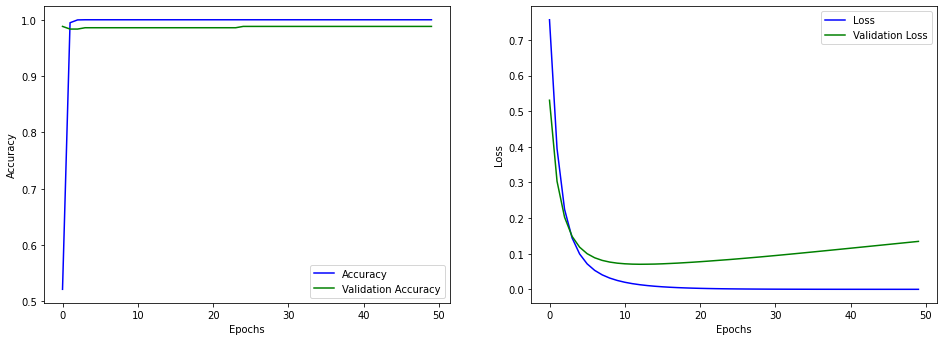

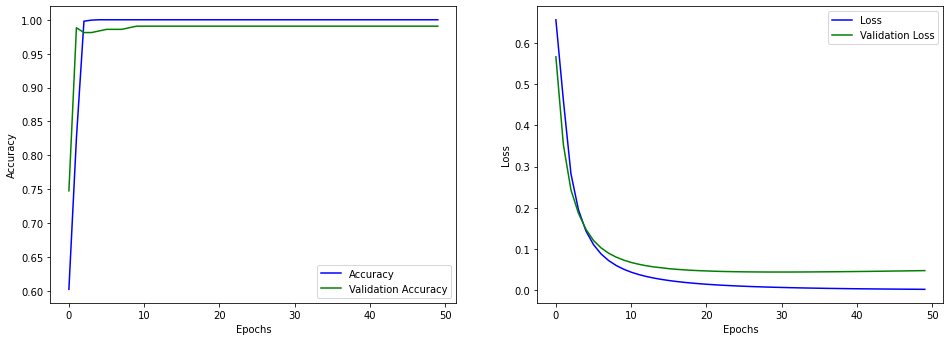

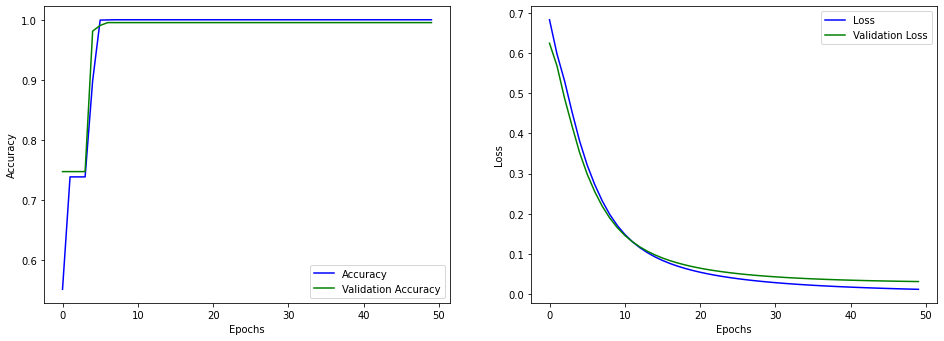

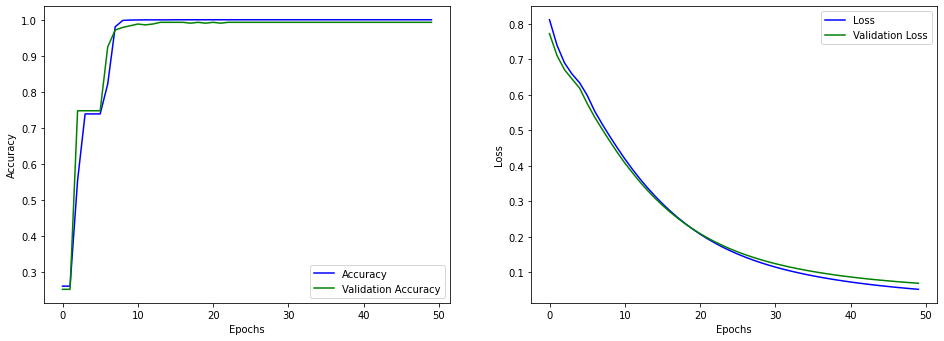

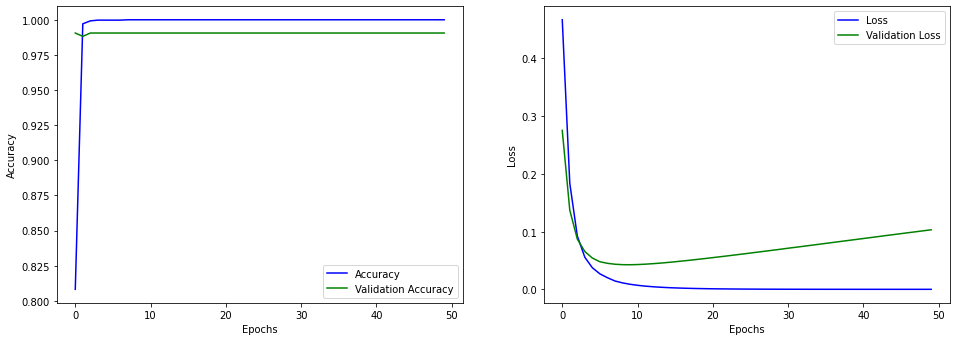

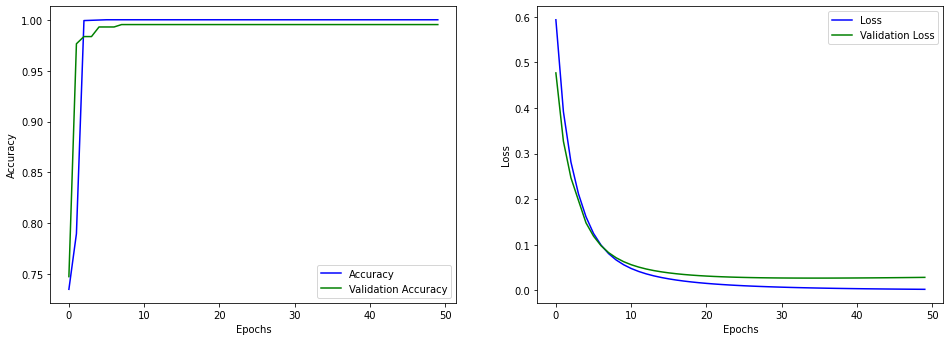

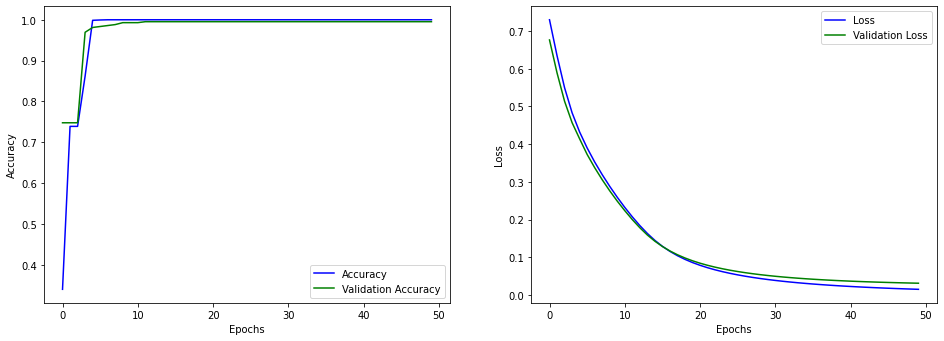

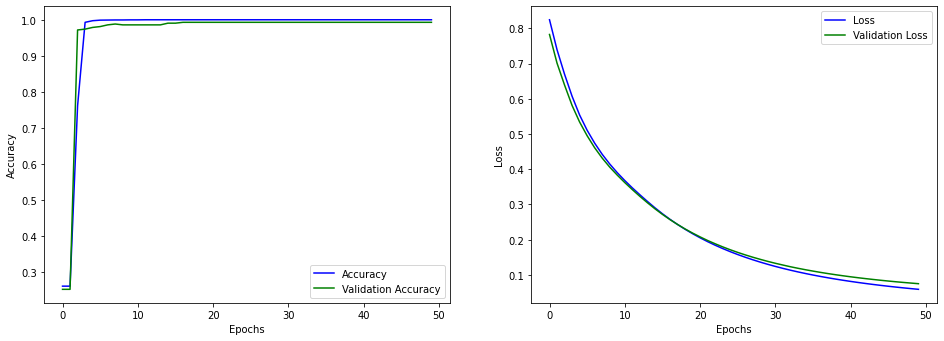

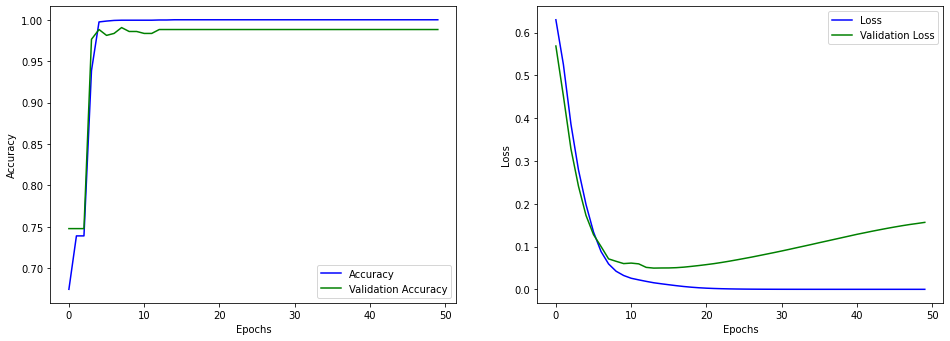

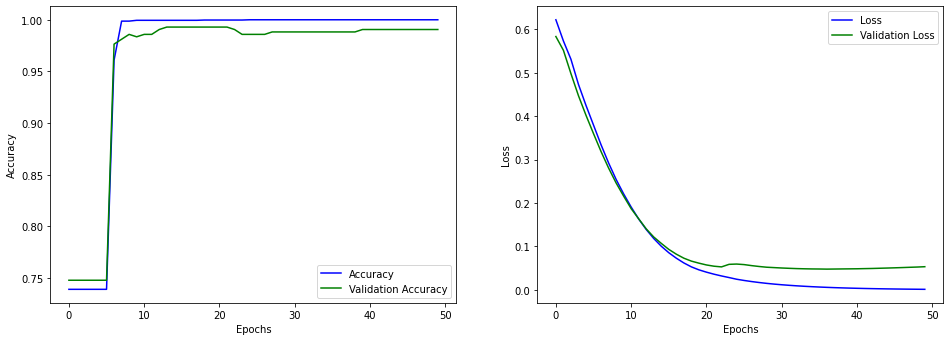

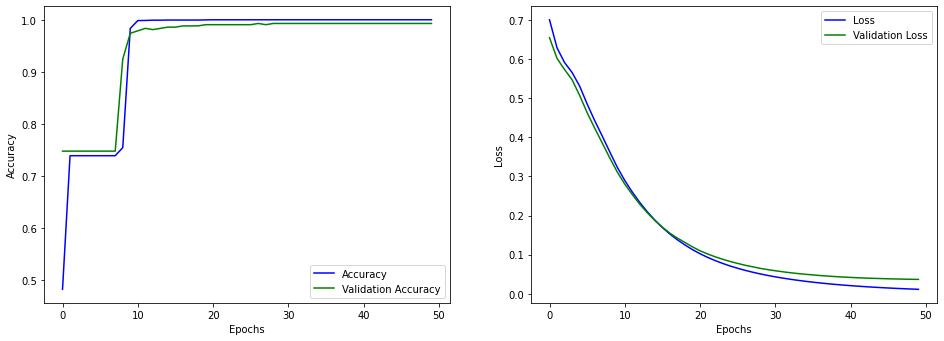

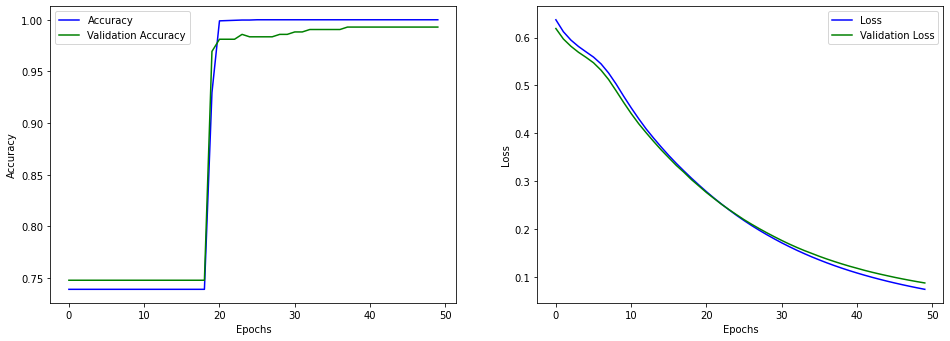

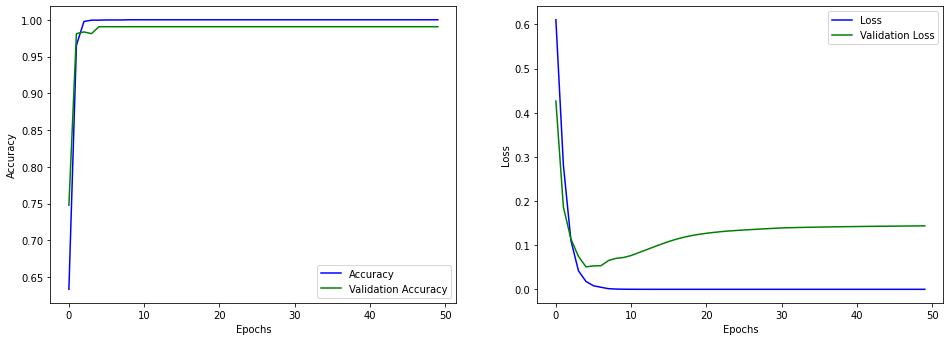

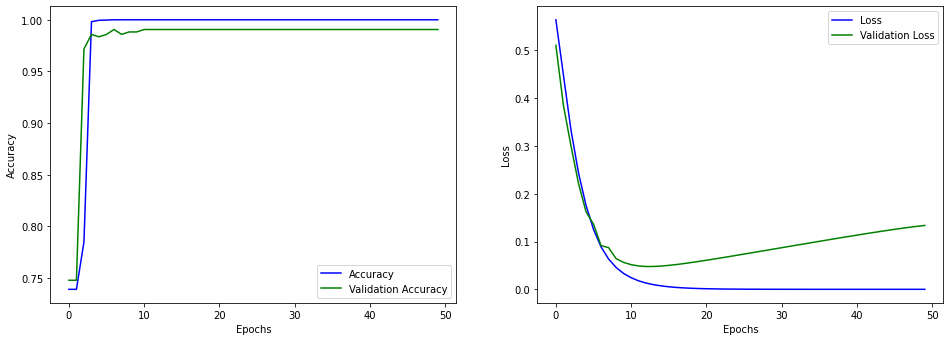

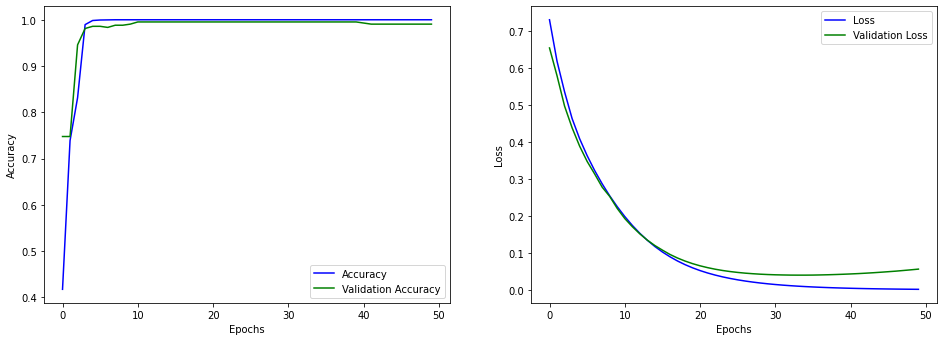

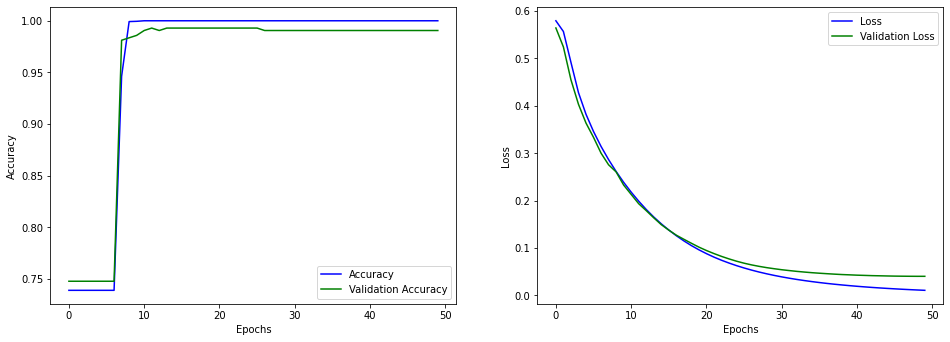

In [ ]:
optimizers = ['Adam','NAdam','AdaMax','RMSprop']
batch_sizes = [10, 32, 64, 128]
n_epochs = 50
filenum = 500

training_details = []

for opt in optimizers:
  for bs in batch_sizes:

    checkpoint_path = f'gdrive/My Drive/Colab Data/training_{filenum}/cp.ckpt'
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

    model = keras.Sequential(
    [
        layers.LSTM(60, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.LSTM(10, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
    ) 

    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

    model.build(input_shape=X_train_tfidf_expanded.shape)

    print(model.summary())

    history = model.fit(X_train_tfidf_expanded, t_train_tfidf, epochs=n_epochs, batch_size=bs, 
                    validation_split=0.1, verbose=1, callbacks=[cp_callback])
    
    results = model.evaluate(X_test_tfidf_expanded, t_test_tfidf, batch_size=bs)

    print(str(opt), ' ', str(bs), ' : ', str(results))

    plot_training(history)

    model.save(f'gdrive/My Drive/Colab Data/training_{filenum}/model')
    training_details.append((model,history,results,f'gdrive/My Drive/Colab Data/training_{filenum}/model',opt,bs,n_epochs))
    filenum = filenum+1

In [ ]:
best_accuracy = 0
best_loss = 999999999999
best_result_a = None
best_result_l = None

for v in training_details:
  print(f'{v[3]}\n\tOptimizer: {str(v[4])}\tBatch Size: {str(v[5])}\n\tTest Accuracy: {(v[2][1])}\n\tTest Loss: {(v[2][0])}')
  if v[2][1] > best_accuracy:
    best_accuracy = v[2][1]
    best_result_a = v 
  if v[2][0] < best_loss:
    best_loss = v[2][0]
    best_result_l = v 

gdrive/My Drive/Colab Data/training_500/model
	Optimizer: Adam	Batch Size: 10
	Test Accuracy: 0.984891414642334
	Test Loss: 0.15319925546646118
gdrive/My Drive/Colab Data/training_501/model
	Optimizer: Adam	Batch Size: 32
	Test Accuracy: 0.9896128177642822
	Test Loss: 0.06766296178102493
gdrive/My Drive/Colab Data/training_502/model
	Optimizer: Adam	Batch Size: 64
	Test Accuracy: 0.9867799878120422
	Test Loss: 0.06040026620030403
gdrive/My Drive/Colab Data/training_503/model
	Optimizer: Adam	Batch Size: 128
	Test Accuracy: 0.9858356714248657
	Test Loss: 0.08479217439889908
gdrive/My Drive/Colab Data/training_504/model
	Optimizer: NAdam	Batch Size: 10
	Test Accuracy: 0.9867799878120422
	Test Loss: 0.14873765408992767
gdrive/My Drive/Colab Data/training_505/model
	Optimizer: NAdam	Batch Size: 32
	Test Accuracy: 0.9905571341514587
	Test Loss: 0.057391438633203506
gdrive/My Drive/Colab Data/training_506/model
	Optimizer: NAdam	Batch Size: 64
	Test Accuracy: 0.9886685609817505
	Test Loss: 0

In [ ]:
print(f'Best accuracy: {best_accuracy}\n\tOptimizer: {str(best_result_a[4])}\n\tBatch Size: {str(best_result_a[5])}\n\tTest Accuracy: {(best_result_a[2][1])}\n\tTest Loss: {(best_result_a[2][0])}')
print(f'Best loss: {best_loss}\n\tOptimizer: {str(best_result_l[4])}\n\tBatch Size: {str(best_result_l[5])}\n\tTest Accuracy: {(best_result_l[2][1])}\n\tTest Loss: {(best_result_l[2][0])}')

Best accuracy: 0.9905571341514587
	Optimizer: NAdam
	Batch Size: 32
	Test Accuracy: 0.9905571341514587
	Test Loss: 0.057391438633203506
Best loss: 0.054838694632053375
	Optimizer: AdaMax
	Batch Size: 64
	Test Accuracy: 0.9896128177642822
	Test Loss: 0.054838694632053375


In [ ]:
pred = best_result_a[0].predict(X_test_tfidf_expanded)
pred = np.round(pred, 0)
report = classification_report(t_test_tfidf, pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       783
           1       0.99      0.98      0.98       276

    accuracy                           0.99      1059
   macro avg       0.99      0.99      0.99      1059
weighted avg       0.99      0.99      0.99      1059



In [ ]:
pred = best_result_l[0].predict(X_test_tfidf_expanded)
pred = np.round(pred, 0)
report = classification_report(t_test_tfidf, pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       783
           1       0.99      0.97      0.98       276

    accuracy                           0.99      1059
   macro avg       0.99      0.98      0.99      1059
weighted avg       0.99      0.99      0.99      1059



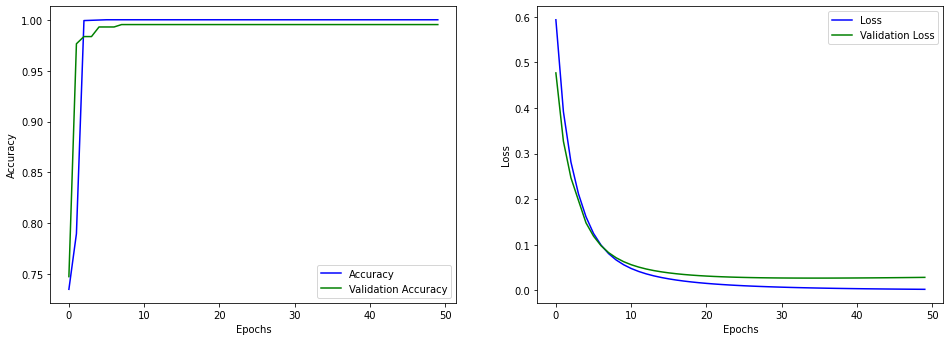

In [ ]:
best_result_a[0].save(f'gdrive/My Drive/Colab Data/testing/best_accuracy_3/model')
plot_training(best_result_a[1])

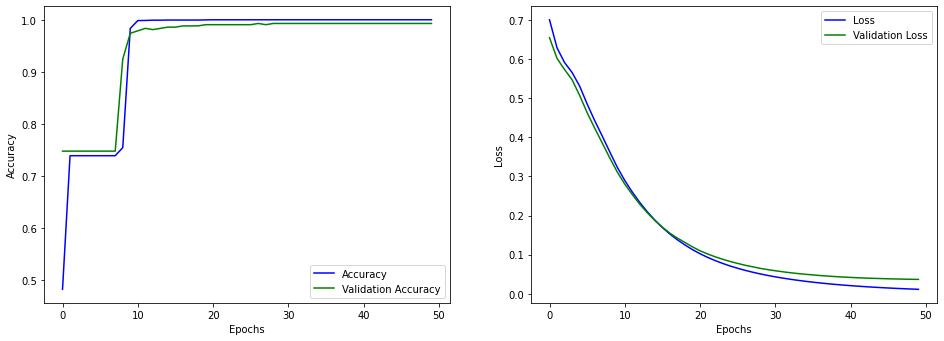

In [ ]:
best_result_l[0].save(f'gdrive/My Drive/Colab Data/testing/best_loss_3/model')
plot_training(best_result_l[1])

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 15,867,931
Trainable params: 15,867,931

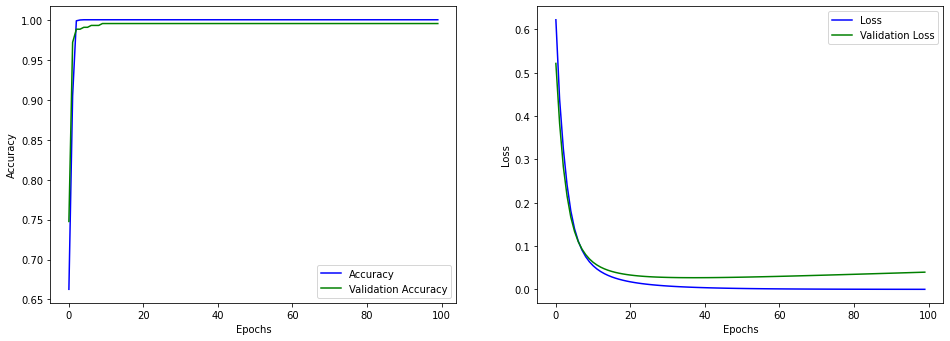

In [ ]:
model = keras.Sequential(
    [
        layers.LSTM(60, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.LSTM(10, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
    ) 

checkpoint_path = f'gdrive/My Drive/Colab Data/training_100/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

model.compile(loss='binary_crossentropy',optimizer='NAdam',metrics=['accuracy'])
model.build(input_shape=X_train_tfidf_expanded.shape)
print(model.summary())

history = model.fit(X_train_tfidf_expanded, t_train_tfidf, epochs=100, batch_size=32, 
                    validation_split=0.1, verbose=1, callbacks=[cp_callback])

results = model.evaluate(X_test_tfidf_expanded, t_test_tfidf, batch_size=32)
plot_training(history)

model.save(f'gdrive/My Drive/Colab Data/training_100/model')

In [ ]:
print(results)

[0.08745614439249039, 0.9886685609817505]


In [ ]:
pred = model.predict(X_test_tfidf_expanded)
pred = np.round(pred, 0)

In [ ]:
report = classification_report(t_test_tfidf, pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       783
           1       0.97      0.98      0.98       276

    accuracy                           0.99      1059
   macro avg       0.98      0.99      0.99      1059
weighted avg       0.99      0.99      0.99      1059



Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 layer5 (Dense)              (None, 4)                 24        
                                                                 
 layer6 (Dense)              (None, 3)               

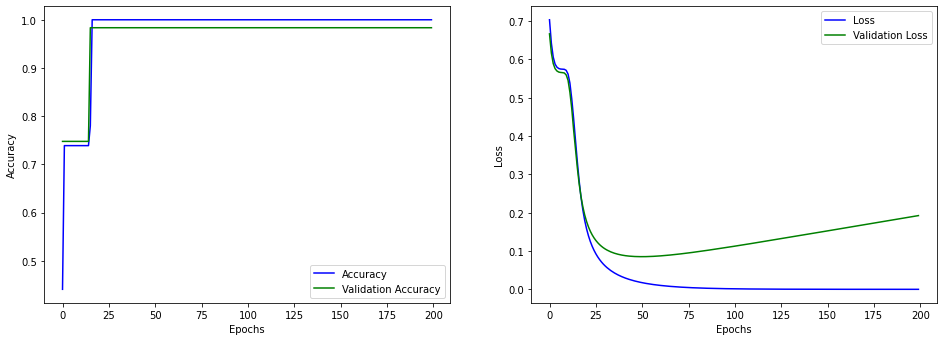

In [ ]:
model = keras.Sequential(
    [
        layers.LSTM(60, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.LSTM(10, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(4, activation='sigmoid', name='layer5'),
        layers.Dense(3, activation='sigmoid', name='layer6'),
        layers.Dense(2, activation='sigmoid', name='layer7'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
    ) 

checkpoint_path = f'gdrive/My Drive/Colab Data/training_101/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

model.compile(loss='binary_crossentropy',optimizer='NAdam',metrics=['accuracy'])
model.build(input_shape=X_train_tfidf_expanded.shape)
print(model.summary())

history = model.fit(X_train_tfidf_expanded, t_train_tfidf, epochs=200, batch_size=32, 
                    validation_split=0.1, verbose=1, callbacks=[cp_callback])

results = model.evaluate(X_test_tfidf_expanded, t_test_tfidf, batch_size=32)
plot_training(history)

model.save(f'gdrive/My Drive/Colab Data/training_101/model')

In [ ]:
print(results)

[0.15410545468330383, 0.9867799878120422]


In [ ]:
pred = model.predict(X_test_tfidf_expanded)
pred = np.round(pred, 0)

In [ ]:
report = classification_report(t_test_tfidf, pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       783
           1       0.99      0.96      0.97       276

    accuracy                           0.99      1059
   macro avg       0.99      0.98      0.98      1059
weighted avg       0.99      0.99      0.99      1059



Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 layer5 (Dense)              (None, 4)                 24        
                                                                 
 layer6 (Dense)              (None, 3)               

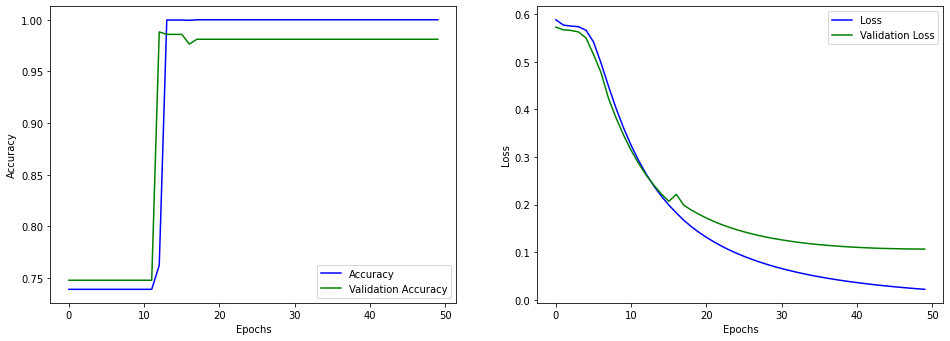

In [ ]:
model = keras.Sequential(
    [
        layers.LSTM(60, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.LSTM(10, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(4, activation='sigmoid', name='layer5'),
        layers.Dense(3, activation='sigmoid', name='layer6'),
        layers.Dense(2, activation='sigmoid', name='layer7'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
    ) 

checkpoint_path = f'gdrive/My Drive/Colab Data/training_102/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

model.compile(loss='binary_crossentropy',optimizer='NAdam',metrics=['accuracy'])
model.build(input_shape=X_train_tfidf_expanded.shape)
print(model.summary())

history = model.fit(X_train_tfidf_expanded, t_train_tfidf, epochs=50, batch_size=32, 
                    validation_split=0.1, verbose=1, callbacks=[cp_callback])

results = model.evaluate(X_test_tfidf_expanded, t_test_tfidf, batch_size=32)
plot_training(history)

model.save(f'gdrive/My Drive/Colab Data/training_102/model')

In [ ]:
print(results)

[0.07570333033800125, 0.9867799878120422]


In [ ]:
pred = model.predict(X_test_tfidf_expanded)
pred = np.round(pred, 0)

In [ ]:
report = classification_report(t_test_tfidf, pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       783
           1       0.98      0.97      0.97       276

    accuracy                           0.99      1059
   macro avg       0.99      0.98      0.98      1059
weighted avg       0.99      0.99      0.99      1059



Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 layer5 (Dense)              (None, 4)                 24        
                                                                 
 layer6 (Dense)              (None, 3)               

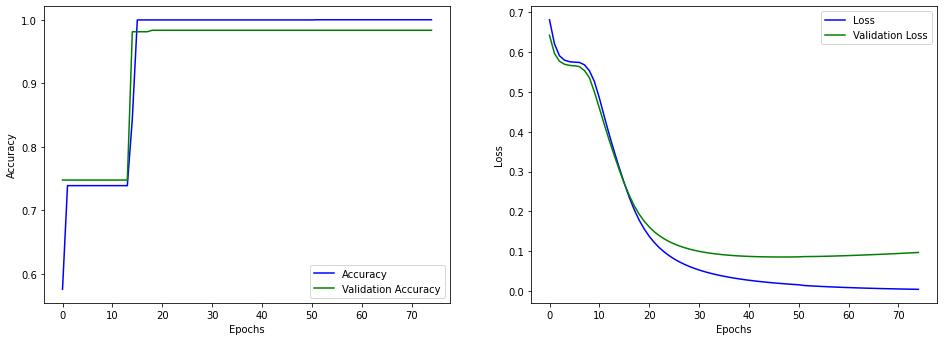

In [ ]:
model = keras.Sequential(
    [
        layers.LSTM(60, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.LSTM(10, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(4, activation='sigmoid', name='layer5'),
        layers.Dense(3, activation='sigmoid', name='layer6'),
        layers.Dense(2, activation='sigmoid', name='layer7'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
    ) 

checkpoint_path = f'gdrive/My Drive/Colab Data/training_103/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

model.compile(loss='binary_crossentropy',optimizer='NAdam',metrics=['accuracy'])
model.build(input_shape=X_train_tfidf_expanded.shape)
print(model.summary())

history = model.fit(X_train_tfidf_expanded, t_train_tfidf, epochs=75, batch_size=32, 
                    validation_split=0.1, verbose=1, callbacks=[cp_callback])

results = model.evaluate(X_test_tfidf_expanded, t_test_tfidf, batch_size=32)
plot_training(history)

model.save(f'gdrive/My Drive/Colab Data/training_103/model')

In [ ]:
print(results)

[0.09739863127470016, 0.9830028414726257]


In [ ]:
pred = model.predict(X_test_tfidf_expanded)
pred = np.round(pred, 0)

In [ ]:
report = classification_report(t_test_tfidf, pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       783
           1       0.97      0.96      0.97       276

    accuracy                           0.98      1059
   macro avg       0.98      0.98      0.98      1059
weighted avg       0.98      0.98      0.98      1059



Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 layer5 (Dense)              (None, 4)                 24        
                                                                 
 layer6 (Dense)              (None, 3)               

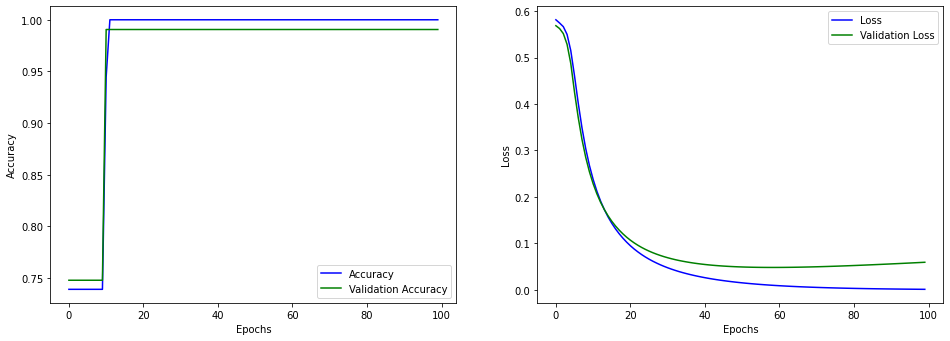

In [ ]:
model = keras.Sequential(
    [
        layers.LSTM(60, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.LSTM(10, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(4, activation='sigmoid', name='layer5'),
        layers.Dense(3, activation='sigmoid', name='layer6'),
        layers.Dense(2, activation='sigmoid', name='layer7'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
    ) 

checkpoint_path = f'gdrive/My Drive/Colab Data/training_104/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

model.compile(loss='binary_crossentropy',optimizer='NAdam',metrics=['accuracy'])
model.build(input_shape=X_train_tfidf_expanded.shape)
print(model.summary())

history = model.fit(X_train_tfidf_expanded, t_train_tfidf, epochs=100, batch_size=32, 
                    validation_split=0.1, verbose=1, callbacks=[cp_callback])

results = model.evaluate(X_test_tfidf_expanded, t_test_tfidf, batch_size=32)
plot_training(history)

model.save(f'gdrive/My Drive/Colab Data/training_104/model')

In [ ]:
print(results)

[0.09981372207403183, 0.9839470982551575]


In [ ]:
pred = model.predict(X_test_tfidf_expanded)
pred = np.round(pred, 0)

In [ ]:
report = classification_report(t_test_tfidf, pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       783
           1       0.95      0.99      0.97       276

    accuracy                           0.98      1059
   macro avg       0.97      0.98      0.98      1059
weighted avg       0.98      0.98      0.98      1059



In [ ]:
plt.close('all')

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 200)            52974400  
                                                                 
 layer1 (Dense)              (None, 1, 60)             12060     
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 layer5 (Dense)              (None, 4)                 24        
                                                                 
 layer6 (Dense)              (None, 3)               

Epoch 1/25
118/120 [============================>.] - ETA: 0s - loss: 0.0634 - accuracy: 1.0000
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_201/cp.ckpt
120/120 [==============================] - 4s 36ms/step - loss: 0.0633 - accuracy: 1.0000 - val_loss: 0.0991 - val_accuracy: 0.9882
Epoch 2/25
118/120 [============================>.] - ETA: 0s - loss: 0.0596 - accuracy: 1.0000
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_201/cp.ckpt
120/120 [==============================] - 4s 37ms/step - loss: 0.0597 - accuracy: 1.0000 - val_loss: 0.0965 - val_accuracy: 0.9882
Epoch 3/25
118/120 [============================>.] - ETA: 0s - loss: 0.0563 - accuracy: 1.0000
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_201/cp.ckpt
120/120 [==============================] - 7s 59ms/step - loss: 0.0563 - accuracy: 1.0000 - val_loss: 0.0940 - val_accuracy: 0.9882
Epoch 4/25
118/120 [============================>.] - ETA: 0s - loss: 0.0532 - accuracy: 1.0000
E

Epoch 1/25
118/120 [============================>.] - ETA: 0s - loss: 0.0162 - accuracy: 1.0000
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_202/cp.ckpt
120/120 [==============================] - 4s 37ms/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.0715 - val_accuracy: 0.9882
Epoch 2/25
118/120 [============================>.] - ETA: 0s - loss: 0.0154 - accuracy: 1.0000
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_202/cp.ckpt
120/120 [==============================] - 4s 37ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 0.0714 - val_accuracy: 0.9882
Epoch 3/25
120/120 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 1.0000
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_202/cp.ckpt
120/120 [==============================] - 4s 36ms/step - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.0713 - val_accuracy: 0.9882
Epoch 4/25
118/120 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 1.0000
E

Epoch 1/50
118/120 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_203/cp.ckpt
120/120 [==============================] - 5s 45ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0758 - val_accuracy: 0.9882
Epoch 2/50
120/120 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_203/cp.ckpt
120/120 [==============================] - 6s 53ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0762 - val_accuracy: 0.9882
Epoch 3/50
118/120 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 1.0000
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_203/cp.ckpt
120/120 [==============================] - 7s 59ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0766 - val_accuracy: 0.9882
Epoch 4/50
118/120 [============================>.] - ETA: 0s - loss: 0.0039 - accuracy: 1.0000
E

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 layer5 (Dense)              (None, 4)                 24        
                                                                 
 layer6 (Dense)              (None, 3)               

Epoch 1/25
117/120 [============================>.] - ETA: 0s - loss: 0.0169 - accuracy: 0.9997
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_205/cp.ckpt
120/120 [==============================] - 3s 23ms/step - loss: 0.0168 - accuracy: 0.9997 - val_loss: 0.0577 - val_accuracy: 0.9882
Epoch 2/25
120/120 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.9997
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_205/cp.ckpt
120/120 [==============================] - 2s 20ms/step - loss: 0.0160 - accuracy: 0.9997 - val_loss: 0.0576 - val_accuracy: 0.9882
Epoch 3/25
117/120 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9997
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_205/cp.ckpt
120/120 [==============================] - 3s 22ms/step - loss: 0.0152 - accuracy: 0.9997 - val_loss: 0.0576 - val_accuracy: 0.9882
Epoch 4/25
120/120 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9997
E

Epoch 1/25
118/120 [============================>.] - ETA: 0s - loss: 0.0057 - accuracy: 0.9997
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_206/cp.ckpt
120/120 [==============================] - 3s 25ms/step - loss: 0.0057 - accuracy: 0.9997 - val_loss: 0.0665 - val_accuracy: 0.9882
Epoch 2/25
118/120 [============================>.] - ETA: 0s - loss: 0.0055 - accuracy: 0.9997
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_206/cp.ckpt
120/120 [==============================] - 3s 22ms/step - loss: 0.0055 - accuracy: 0.9997 - val_loss: 0.0669 - val_accuracy: 0.9882
Epoch 3/25
120/120 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9997
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_206/cp.ckpt
120/120 [==============================] - 3s 22ms/step - loss: 0.0053 - accuracy: 0.9997 - val_loss: 0.0676 - val_accuracy: 0.9882
Epoch 4/25
117/120 [============================>.] - ETA: 0s - loss: 0.0052 - accuracy: 0.9997
E

Epoch 1/50
119/120 [============================>.] - ETA: 0s - loss: 0.0030 - accuracy: 0.9997
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_207/cp.ckpt
120/120 [==============================] - 3s 24ms/step - loss: 0.0030 - accuracy: 0.9997 - val_loss: 0.0811 - val_accuracy: 0.9882
Epoch 2/50
118/120 [============================>.] - ETA: 0s - loss: 0.0030 - accuracy: 0.9997
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_207/cp.ckpt
120/120 [==============================] - 2s 20ms/step - loss: 0.0029 - accuracy: 0.9997 - val_loss: 0.0816 - val_accuracy: 0.9882
Epoch 3/50
117/120 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9997
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_207/cp.ckpt
120/120 [==============================] - 3s 21ms/step - loss: 0.0029 - accuracy: 0.9997 - val_loss: 0.0822 - val_accuracy: 0.9882
Epoch 4/50
117/120 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9997
E

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer3 (LSTM)               (None, 60)                29040     
                                                                 
 layer4 (Dense)              (None, 10)                610       
                                                                 
 layer5 (Dense)              (None, 8)                 88        
                                                                 
 layer6 (Dense)              (None, 6)               

Epoch 1/25
119/120 [============================>.] - ETA: 0s - loss: 0.0050 - accuracy: 0.9997
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_209/cp.ckpt
120/120 [==============================] - 3s 25ms/step - loss: 0.0049 - accuracy: 0.9997 - val_loss: 0.0979 - val_accuracy: 0.9835
Epoch 2/25
117/120 [============================>.] - ETA: 0s - loss: 0.0048 - accuracy: 0.9997
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_209/cp.ckpt
120/120 [==============================] - 4s 33ms/step - loss: 0.0048 - accuracy: 0.9997 - val_loss: 0.0987 - val_accuracy: 0.9835
Epoch 3/25
118/120 [============================>.] - ETA: 0s - loss: 0.0046 - accuracy: 0.9997
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_209/cp.ckpt
120/120 [==============================] - 3s 21ms/step - loss: 0.0046 - accuracy: 0.9997 - val_loss: 0.0995 - val_accuracy: 0.9835
Epoch 4/25
120/120 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9997
E

Epoch 1/25
117/120 [============================>.] - ETA: 0s - loss: 9.3397e-04 - accuracy: 1.0000
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_210/cp.ckpt
120/120 [==============================] - 3s 26ms/step - loss: 9.3216e-04 - accuracy: 1.0000 - val_loss: 0.1051 - val_accuracy: 0.9858
Epoch 2/25
118/120 [============================>.] - ETA: 0s - loss: 8.8070e-04 - accuracy: 1.0000
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_210/cp.ckpt
120/120 [==============================] - 3s 21ms/step - loss: 8.8055e-04 - accuracy: 1.0000 - val_loss: 0.1058 - val_accuracy: 0.9858
Epoch 3/25
120/120 [==============================] - ETA: 0s - loss: 8.3139e-04 - accuracy: 1.0000
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_210/cp.ckpt
120/120 [==============================] - 3s 26ms/step - loss: 8.3139e-04 - accuracy: 1.0000 - val_loss: 0.1066 - val_accuracy: 0.9858
Epoch 4/25
118/120 [============================>.] - ETA: 0s - loss: 7.8

Epoch 1/50
119/120 [============================>.] - ETA: 0s - loss: 2.2507e-04 - accuracy: 1.0000
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_211/cp.ckpt
120/120 [==============================] - 3s 23ms/step - loss: 2.2528e-04 - accuracy: 1.0000 - val_loss: 0.1245 - val_accuracy: 0.9858
Epoch 2/50
118/120 [============================>.] - ETA: 0s - loss: 2.1264e-04 - accuracy: 1.0000
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_211/cp.ckpt
120/120 [==============================] - 3s 24ms/step - loss: 2.1274e-04 - accuracy: 1.0000 - val_loss: 0.1253 - val_accuracy: 0.9858
Epoch 3/50
118/120 [============================>.] - ETA: 0s - loss: 2.0092e-04 - accuracy: 1.0000
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_211/cp.ckpt
120/120 [==============================] - 3s 22ms/step - loss: 2.0101e-04 - accuracy: 1.0000 - val_loss: 0.1261 - val_accuracy: 0.9858
Epoch 4/50
120/120 [==============================] - ETA: 0s - loss: 1.9

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 60)             15858720  
                                                                 
 layer1 (Dense)              (None, 1, 60)             3660      
                                                                 
 layer2 (Dense)              (None, 1, 50)             3050      
                                                                 
 layer3 (LSTM)               (None, 10)                2440      
                                                                 
 layer4 (Dense)              (None, 5)                 55        
                                                                 
 layer5 (Dense)              (None, 4)                 24        
                                                                 
 layer6 (Dense)              (None, 3)               

Epoch 1/25
117/120 [============================>.] - ETA: 0s - loss: 0.1717 - accuracy: 0.9362
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_213/cp.ckpt
120/120 [==============================] - 3s 24ms/step - loss: 0.1729 - accuracy: 0.9352 - val_loss: 0.1084 - val_accuracy: 0.9858
Epoch 2/25
120/120 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9333
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_213/cp.ckpt
120/120 [==============================] - 3s 22ms/step - loss: 0.1750 - accuracy: 0.9333 - val_loss: 0.1055 - val_accuracy: 0.9858
Epoch 3/25
118/120 [============================>.] - ETA: 0s - loss: 0.1745 - accuracy: 0.9327
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_213/cp.ckpt
120/120 [==============================] - 3s 26ms/step - loss: 0.1756 - accuracy: 0.9323 - val_loss: 0.1030 - val_accuracy: 0.9858
Epoch 4/25
117/120 [============================>.] - ETA: 0s - loss: 0.1628 - accuracy: 0.9383
E

Epoch 1/25
117/120 [============================>.] - ETA: 0s - loss: 0.1490 - accuracy: 0.9335
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_214/cp.ckpt
120/120 [==============================] - 3s 24ms/step - loss: 0.1486 - accuracy: 0.9339 - val_loss: 0.1102 - val_accuracy: 0.9788
Epoch 2/25
117/120 [============================>.] - ETA: 0s - loss: 0.1468 - accuracy: 0.9391
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_214/cp.ckpt
120/120 [==============================] - 3s 26ms/step - loss: 0.1474 - accuracy: 0.9388 - val_loss: 0.1103 - val_accuracy: 0.9788
Epoch 3/25
117/120 [============================>.] - ETA: 0s - loss: 0.1463 - accuracy: 0.9364
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_214/cp.ckpt
120/120 [==============================] - 3s 21ms/step - loss: 0.1468 - accuracy: 0.9362 - val_loss: 0.1104 - val_accuracy: 0.9788
Epoch 4/25
120/120 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.9370
E

Epoch 1/50
119/120 [============================>.] - ETA: 0s - loss: 0.1344 - accuracy: 0.9430
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_215/cp.ckpt
120/120 [==============================] - 3s 23ms/step - loss: 0.1344 - accuracy: 0.9430 - val_loss: 0.1176 - val_accuracy: 0.9788
Epoch 2/50
119/120 [============================>.] - ETA: 0s - loss: 0.1526 - accuracy: 0.9299
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_215/cp.ckpt
120/120 [==============================] - 3s 23ms/step - loss: 0.1526 - accuracy: 0.9299 - val_loss: 0.1180 - val_accuracy: 0.9788
Epoch 3/50
120/120 [==============================] - ETA: 0s - loss: 0.1442 - accuracy: 0.9339
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_215/cp.ckpt
120/120 [==============================] - 3s 22ms/step - loss: 0.1442 - accuracy: 0.9339 - val_loss: 0.1184 - val_accuracy: 0.9788
Epoch 4/50
120/120 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9320
E

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (LSTM)                (None, 1, 5)              1320460   
                                                                 
 layer1 (Dense)              (None, 1, 5)              30        
                                                                 
 layer2 (Dense)              (None, 1, 5)              30        
                                                                 
 layer3 (LSTM)               (None, 5)                 220       
                                                                 
 layer4 (Dense)              (None, 5)                 30        
                                                                 
 layer5 (Dense)              (None, 5)                 30        
                                                                 
 layer6 (Dense)              (None, 4)               

Epoch 1/25
117/120 [============================>.] - ETA: 0s - loss: 0.3242 - accuracy: 0.7094
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_217/cp.ckpt
120/120 [==============================] - 2s 19ms/step - loss: 0.3227 - accuracy: 0.7113 - val_loss: 0.3008 - val_accuracy: 0.7476
Epoch 2/25
117/120 [============================>.] - ETA: 0s - loss: 0.3077 - accuracy: 0.7113
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_217/cp.ckpt
120/120 [==============================] - 2s 15ms/step - loss: 0.3082 - accuracy: 0.7102 - val_loss: 0.2853 - val_accuracy: 0.7476
Epoch 3/25
117/120 [============================>.] - ETA: 0s - loss: 0.2918 - accuracy: 0.7911
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_217/cp.ckpt
120/120 [==============================] - 2s 17ms/step - loss: 0.2920 - accuracy: 0.7913 - val_loss: 0.2709 - val_accuracy: 0.7476
Epoch 4/25
117/120 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.8048
E

Epoch 1/25
117/120 [============================>.] - ETA: 0s - loss: 0.1602 - accuracy: 0.9541
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_218/cp.ckpt
120/120 [==============================] - 2s 17ms/step - loss: 0.1599 - accuracy: 0.9546 - val_loss: 0.1570 - val_accuracy: 0.9788
Epoch 2/25
120/120 [==============================] - ETA: 0s - loss: 0.1631 - accuracy: 0.9514
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_218/cp.ckpt
120/120 [==============================] - 2s 16ms/step - loss: 0.1631 - accuracy: 0.9514 - val_loss: 0.1565 - val_accuracy: 0.9788
Epoch 3/25
117/120 [============================>.] - ETA: 0s - loss: 0.1601 - accuracy: 0.9525
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_218/cp.ckpt
120/120 [==============================] - 2s 17ms/step - loss: 0.1595 - accuracy: 0.9528 - val_loss: 0.1563 - val_accuracy: 0.9788
Epoch 4/25
117/120 [============================>.] - ETA: 0s - loss: 0.1597 - accuracy: 0.9517
E

Epoch 1/50
120/120 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.9541
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_219/cp.ckpt
120/120 [==============================] - 2s 19ms/step - loss: 0.1366 - accuracy: 0.9541 - val_loss: 0.1686 - val_accuracy: 0.9788
Epoch 2/50
117/120 [============================>.] - ETA: 0s - loss: 0.1277 - accuracy: 0.9589
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_219/cp.ckpt
120/120 [==============================] - 2s 17ms/step - loss: 0.1278 - accuracy: 0.9588 - val_loss: 0.1692 - val_accuracy: 0.9788
Epoch 3/50
117/120 [============================>.] - ETA: 0s - loss: 0.1392 - accuracy: 0.9522
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_219/cp.ckpt
120/120 [==============================] - 2s 17ms/step - loss: 0.1383 - accuracy: 0.9528 - val_loss: 0.1705 - val_accuracy: 0.9788
Epoch 4/50
117/120 [============================>.] - ETA: 0s - loss: 0.1446 - accuracy: 0.9490
E

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 1, 50)             3300900   
                                                                 
 layer1 (Dense)              (None, 1, 50)             2550      
                                                                 
 layer2 (Dense)              (None, 1, 50)             2550      
                                                                 
 layer3 (Dense)              (None, 1, 50)             2550      
                                                                 
 layer4 (Dense)              (None, 1, 50)             2550      
                                                                 
 layer5 (Dense)              (None, 1, 50)             2550      
                                                                 
 dropout_10 (Dropout)        (None, 1, 50)           

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/25
115/120 [===========================>..] - ETA: 0s - loss: 6.9441e-05 - accuracy: 1.0000
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_221/cp.ckpt
120/120 [==============================] - 2s 13ms/step - loss: 6.9342e-05 - accuracy: 1.0000 - val_loss: 0.1449 - val_accuracy: 0.9858
Epoch 2/25
115/120 [===========================>..] - ETA: 0s - loss: 6.8670e-05 - accuracy: 1.0000
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_221/cp.ckpt
120/120 [==============================] - 1s 10ms/step - loss: 6.9057e-05 - accuracy: 1.0000 - val_loss: 0.1460 - val_accuracy: 0.9858
Epoch 3/25
114/120 [===========================>..] - ETA: 0s - loss: 6.1485e-05 - accuracy: 1.0000
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_221/cp.ckpt
120/120 [==============================] - 1s 10ms/step - loss: 6.1394e-05 - accuracy: 1.0000 - val_loss: 0.1470 - val_accuracy: 0.9858
Epoch 4/25
116/120 [============================>.] - ETA: 0s - loss: 5.4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/25
115/120 [===========================>..] - ETA: 0s - loss: 1.6413e-05 - accuracy: 1.0000
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_222/cp.ckpt
120/120 [==============================] - 2s 14ms/step - loss: 1.6392e-05 - accuracy: 1.0000 - val_loss: 0.1695 - val_accuracy: 0.9858
Epoch 2/25
115/120 [===========================>..] - ETA: 0s - loss: 1.6079e-05 - accuracy: 1.0000
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_222/cp.ckpt
120/120 [==============================] - 1s 12ms/step - loss: 1.6034e-05 - accuracy: 1.0000 - val_loss: 0.1706 - val_accuracy: 0.9858
Epoch 3/25
116/120 [============================>.] - ETA: 0s - loss: 1.5527e-05 - accuracy: 1.0000
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_222/cp.ckpt
120/120 [==============================] - 1s 12ms/step - loss: 1.5469e-05 - accuracy: 1.0000 - val_loss: 0.1717 - val_accuracy: 0.9858
Epoch 4/25
119/120 [============================>.] - ETA: 0s - loss: 1.3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/50
119/120 [============================>.] - ETA: 0s - loss: 3.9858e-06 - accuracy: 1.0000
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_223/cp.ckpt
120/120 [==============================] - 2s 14ms/step - loss: 3.9839e-06 - accuracy: 1.0000 - val_loss: 0.1951 - val_accuracy: 0.9858
Epoch 2/50
119/120 [============================>.] - ETA: 0s - loss: 3.7905e-06 - accuracy: 1.0000
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_223/cp.ckpt
120/120 [==============================] - 1s 10ms/step - loss: 3.7891e-06 - accuracy: 1.0000 - val_loss: 0.1962 - val_accuracy: 0.9858
Epoch 3/50
117/120 [============================>.] - ETA: 0s - loss: 3.5845e-06 - accuracy: 1.0000
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_223/cp.ckpt
120/120 [==============================] - 1s 11ms/step - loss: 3.6004e-06 - accuracy: 1.0000 - val_loss: 0.1973 - val_accuracy: 0.9858
Epoch 4/50
116/120 [============================>.] - ETA: 0s - loss: 3.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 1, 50)             3300900   
                                                                 
 layer1 (Dense)              (None, 1, 50)             2550      
                                                                 
 dropout_11 (Dropout)        (None, 1, 50)             0         
                                                                 
 flatten_11 (Flatten)        (None, 50)                0         
                                                                 
 layer2 (Dense)              (None, 50)                2550      
                                                                 
 layer3 (Dense)              (None, 50)                2550      
                                                                 
 layer4 (Dense)              (None, 50)              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/25
115/120 [===========================>..] - ETA: 0s - loss: 4.8068e-05 - accuracy: 1.0000
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_225/cp.ckpt
120/120 [==============================] - 2s 13ms/step - loss: 4.7509e-05 - accuracy: 1.0000 - val_loss: 0.1497 - val_accuracy: 0.9858
Epoch 2/25
115/120 [===========================>..] - ETA: 0s - loss: 4.5071e-05 - accuracy: 1.0000
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_225/cp.ckpt
120/120 [==============================] - 1s 11ms/step - loss: 4.6339e-05 - accuracy: 1.0000 - val_loss: 0.1507 - val_accuracy: 0.9858
Epoch 3/25
114/120 [===========================>..] - ETA: 0s - loss: 4.2488e-05 - accuracy: 1.0000
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_225/cp.ckpt
120/120 [==============================] - 1s 10ms/step - loss: 4.2318e-05 - accuracy: 1.0000 - val_loss: 0.1517 - val_accuracy: 0.9858
Epoch 4/25
117/120 [============================>.] - ETA: 0s - loss: 3.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/25
119/120 [============================>.] - ETA: 0s - loss: 1.0747e-05 - accuracy: 1.0000
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_226/cp.ckpt
120/120 [==============================] - 2s 13ms/step - loss: 1.0749e-05 - accuracy: 1.0000 - val_loss: 0.1721 - val_accuracy: 0.9858
Epoch 2/25
115/120 [===========================>..] - ETA: 0s - loss: 1.0489e-05 - accuracy: 1.0000
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_226/cp.ckpt
120/120 [==============================] - 1s 10ms/step - loss: 1.0360e-05 - accuracy: 1.0000 - val_loss: 0.1728 - val_accuracy: 0.9858
Epoch 3/25
118/120 [============================>.] - ETA: 0s - loss: 1.0255e-05 - accuracy: 1.0000
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_226/cp.ckpt
120/120 [==============================] - 1s 10ms/step - loss: 1.0218e-05 - accuracy: 1.0000 - val_loss: 0.1736 - val_accuracy: 0.9858
Epoch 4/25
115/120 [===========================>..] - ETA: 0s - loss: 1.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/50
120/120 [==============================] - ETA: 0s - loss: 2.7052e-06 - accuracy: 1.0000
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_227/cp.ckpt
120/120 [==============================] - 2s 13ms/step - loss: 2.7052e-06 - accuracy: 1.0000 - val_loss: 0.1959 - val_accuracy: 0.9858
Epoch 2/50
113/120 [===========================>..] - ETA: 0s - loss: 2.5417e-06 - accuracy: 1.0000
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_227/cp.ckpt
120/120 [==============================] - 1s 9ms/step - loss: 2.5695e-06 - accuracy: 1.0000 - val_loss: 0.1968 - val_accuracy: 0.9858
Epoch 3/50
120/120 [==============================] - ETA: 0s - loss: 2.3579e-06 - accuracy: 1.0000
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_227/cp.ckpt
120/120 [==============================] - 1s 10ms/step - loss: 2.3579e-06 - accuracy: 1.0000 - val_loss: 0.1979 - val_accuracy: 0.9858
Epoch 4/50
119/120 [============================>.] - ETA: 0s - loss: 2.23

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 1, 50)             3300900   
                                                                 
 layer1 (Dense)              (None, 1, 50)             2550      
                                                                 
 dropout_13 (Dropout)        (None, 1, 50)             0         
                                                                 
 flatten_13 (Flatten)        (None, 50)                0         
                                                                 
 layer2 (Dense)              (None, 50)                2550      
                                                                 
 layer3 (Dense)              (None, 50)                2550      
                                                                 
 dropout_14 (Dropout)        (None, 50)              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/25
119/120 [============================>.] - ETA: 0s - loss: 5.2850e-05 - accuracy: 1.0000
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_229/cp.ckpt
120/120 [==============================] - 2s 15ms/step - loss: 5.2853e-05 - accuracy: 1.0000 - val_loss: 0.0895 - val_accuracy: 0.9906
Epoch 2/25
116/120 [============================>.] - ETA: 0s - loss: 5.0729e-05 - accuracy: 1.0000
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_229/cp.ckpt
120/120 [==============================] - 1s 10ms/step - loss: 5.0337e-05 - accuracy: 1.0000 - val_loss: 0.0902 - val_accuracy: 0.9906
Epoch 3/25
115/120 [===========================>..] - ETA: 0s - loss: 4.2683e-05 - accuracy: 1.0000
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_229/cp.ckpt
120/120 [==============================] - 1s 11ms/step - loss: 4.2696e-05 - accuracy: 1.0000 - val_loss: 0.0909 - val_accuracy: 0.9906
Epoch 4/25
115/120 [===========================>..] - ETA: 0s - loss: 4.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/25
114/120 [===========================>..] - ETA: 0s - loss: 1.2441e-05 - accuracy: 1.0000
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_230/cp.ckpt
120/120 [==============================] - 2s 13ms/step - loss: 1.2653e-05 - accuracy: 1.0000 - val_loss: 0.1083 - val_accuracy: 0.9906
Epoch 2/25
115/120 [===========================>..] - ETA: 0s - loss: 1.1626e-05 - accuracy: 1.0000
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_230/cp.ckpt
120/120 [==============================] - 1s 11ms/step - loss: 1.1564e-05 - accuracy: 1.0000 - val_loss: 0.1091 - val_accuracy: 0.9906
Epoch 3/25
120/120 [==============================] - ETA: 0s - loss: 8.6899e-06 - accuracy: 1.0000
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_230/cp.ckpt
120/120 [==============================] - 1s 11ms/step - loss: 8.6899e-06 - accuracy: 1.0000 - val_loss: 0.1097 - val_accuracy: 0.9906
Epoch 4/25
117/120 [============================>.] - ETA: 0s - loss: 9.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 1/50
115/120 [===========================>..] - ETA: 0s - loss: 2.6188e-06 - accuracy: 1.0000
Epoch 1: saving model to gdrive/My Drive/Colab Data/training_231/cp.ckpt
120/120 [==============================] - 2s 14ms/step - loss: 2.5808e-06 - accuracy: 1.0000 - val_loss: 0.1252 - val_accuracy: 0.9906
Epoch 2/50
114/120 [===========================>..] - ETA: 0s - loss: 2.4381e-06 - accuracy: 1.0000
Epoch 2: saving model to gdrive/My Drive/Colab Data/training_231/cp.ckpt
120/120 [==============================] - 1s 10ms/step - loss: 2.4151e-06 - accuracy: 1.0000 - val_loss: 0.1259 - val_accuracy: 0.9906
Epoch 3/50
120/120 [==============================] - ETA: 0s - loss: 2.5652e-06 - accuracy: 1.0000
Epoch 3: saving model to gdrive/My Drive/Colab Data/training_231/cp.ckpt
120/120 [==============================] - 1s 10ms/step - loss: 2.5652e-06 - accuracy: 1.0000 - val_loss: 0.1266 - val_accuracy: 0.9906
Epoch 4/50
120/120 [==============================] - ETA: 0s - loss: 2.4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


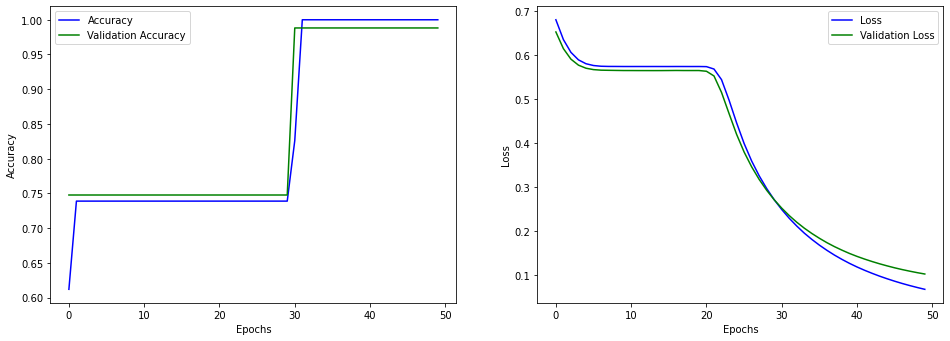

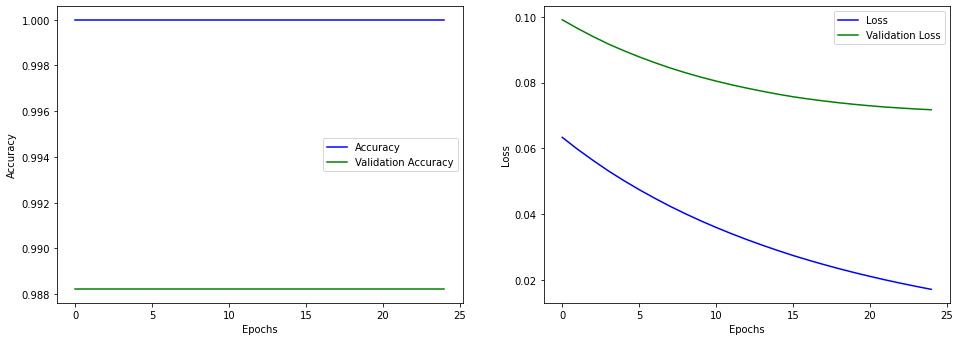

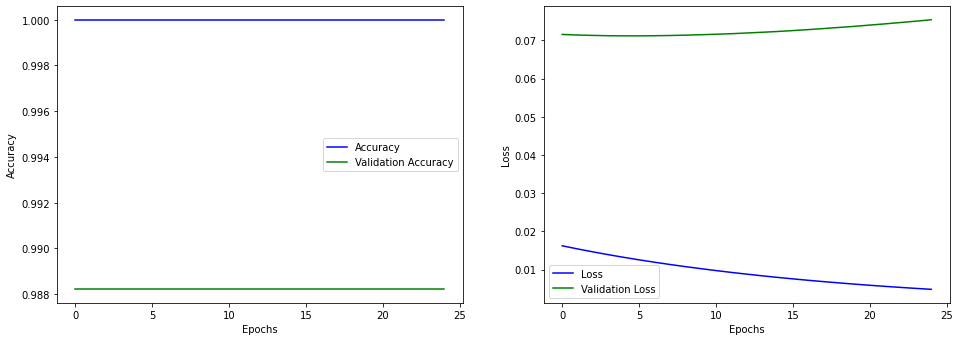

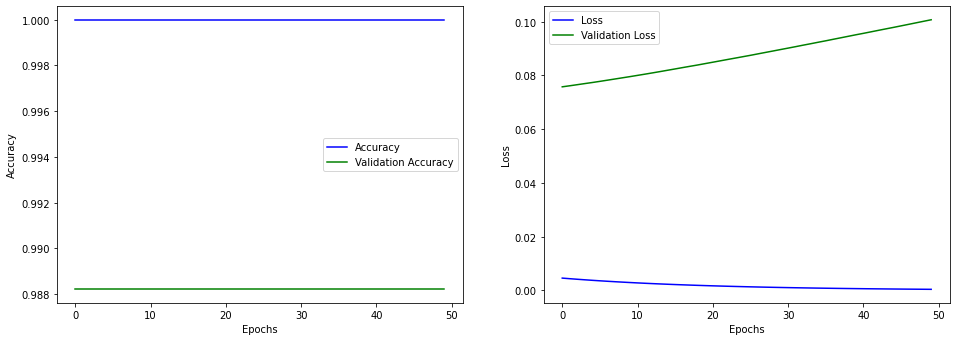

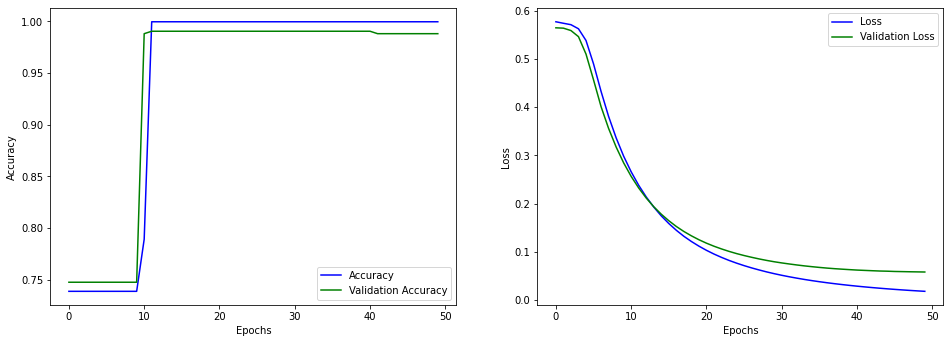

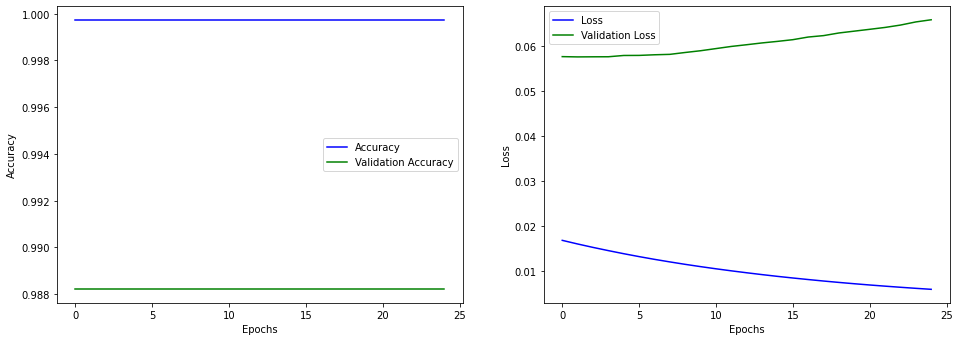

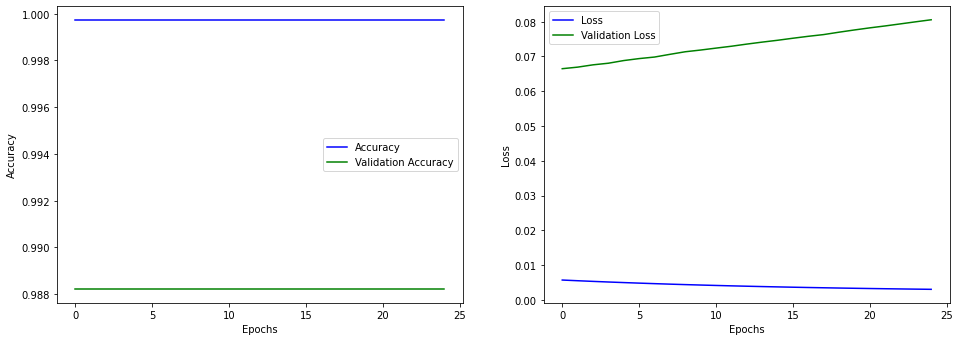

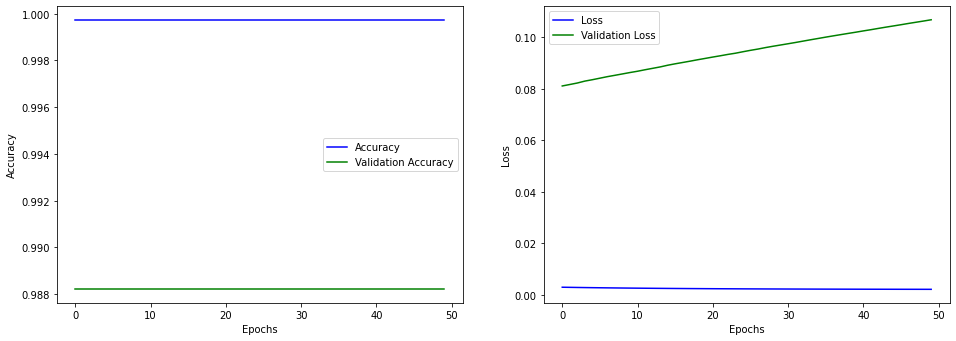

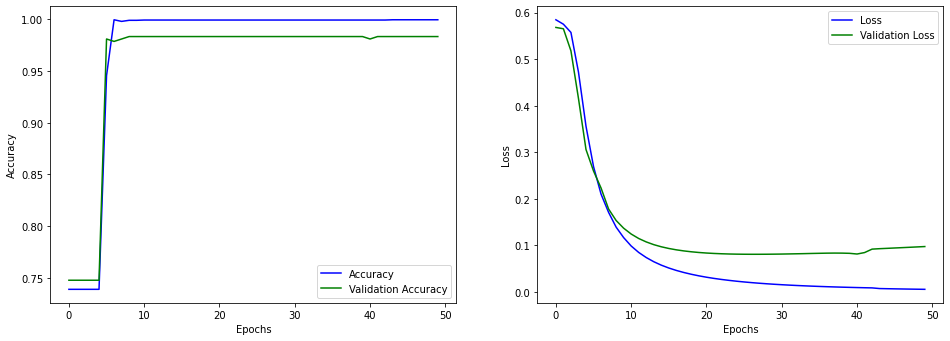

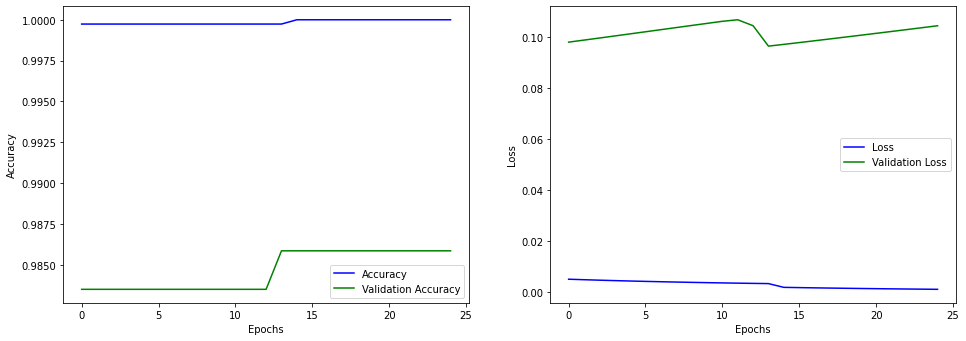

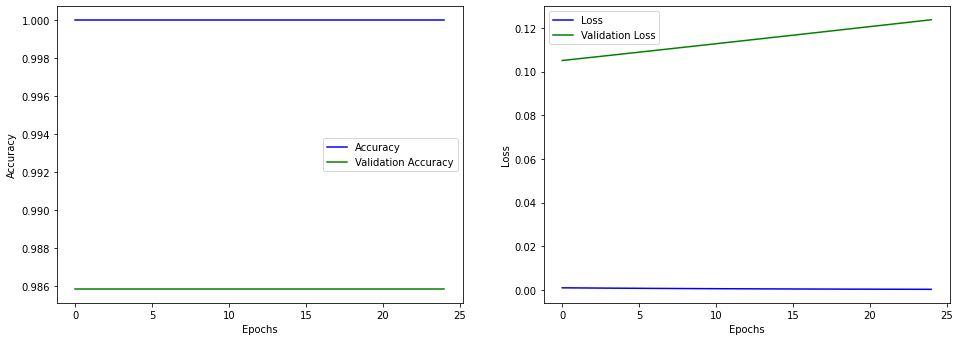

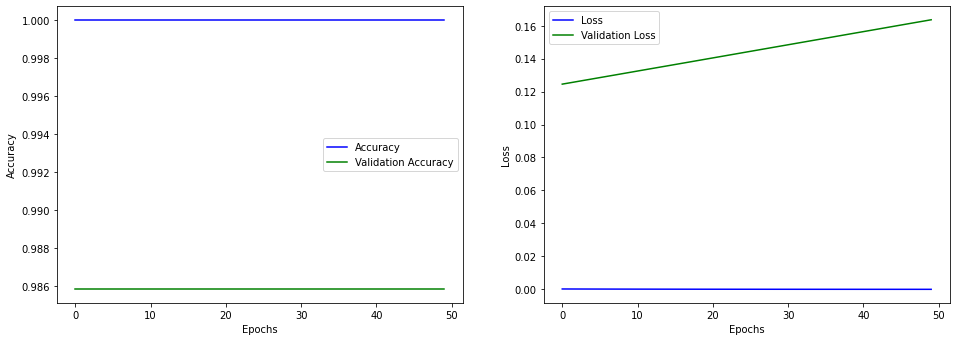

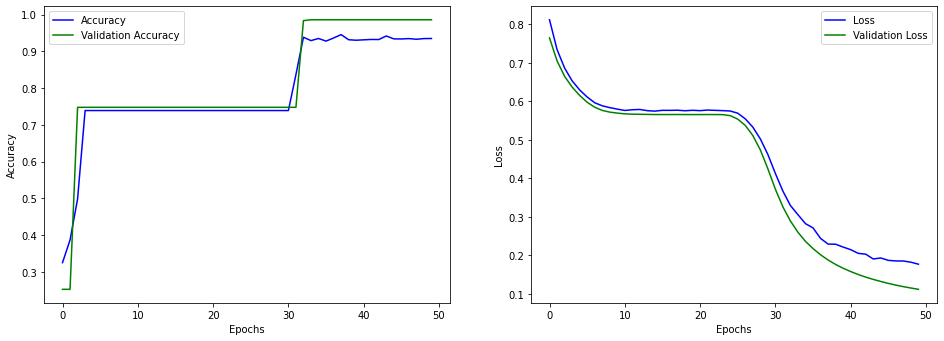

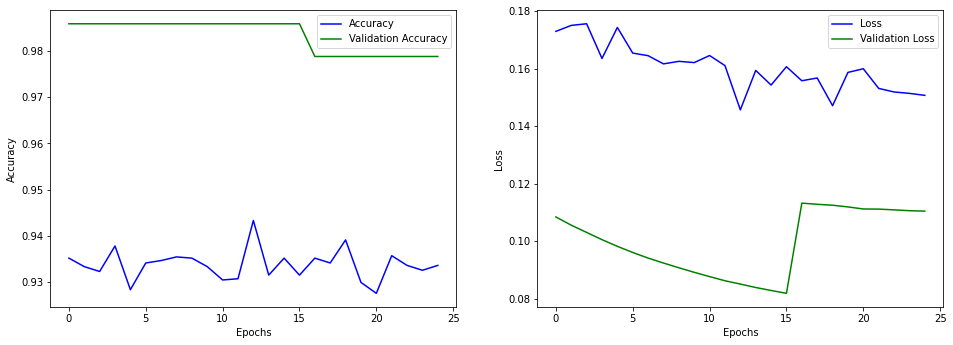

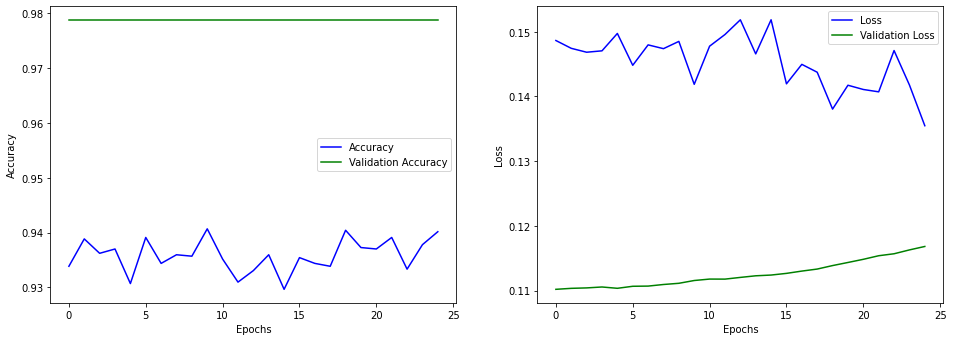

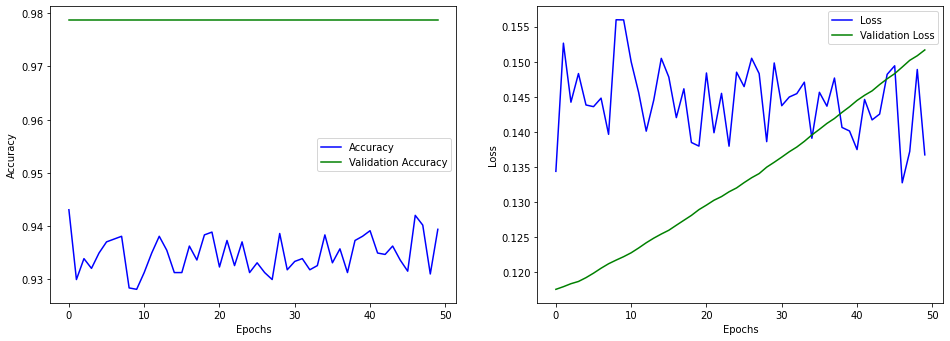

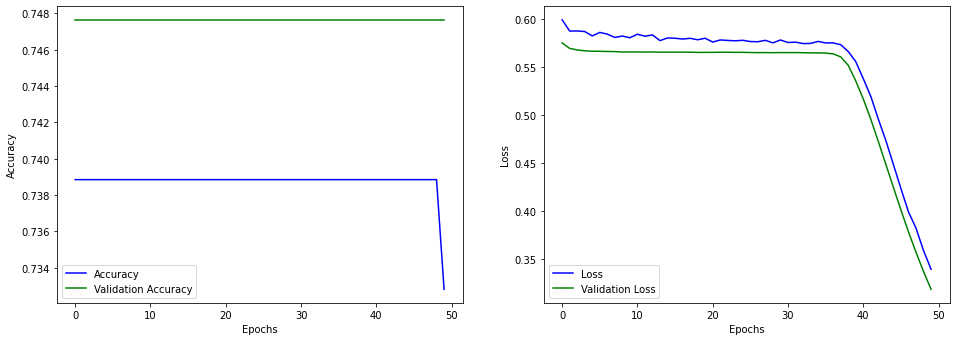

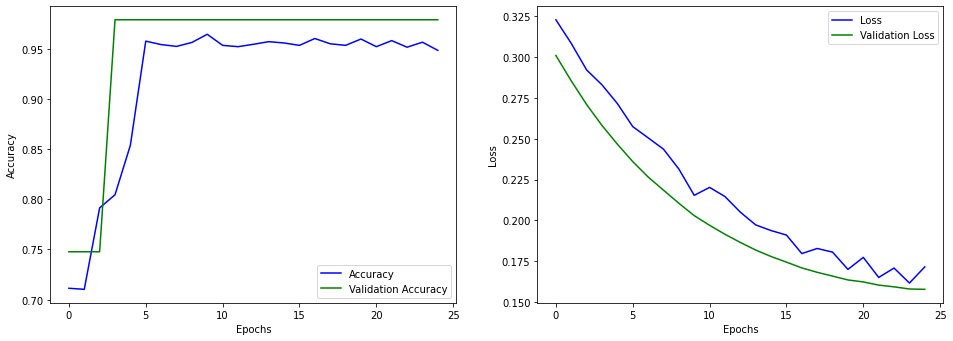

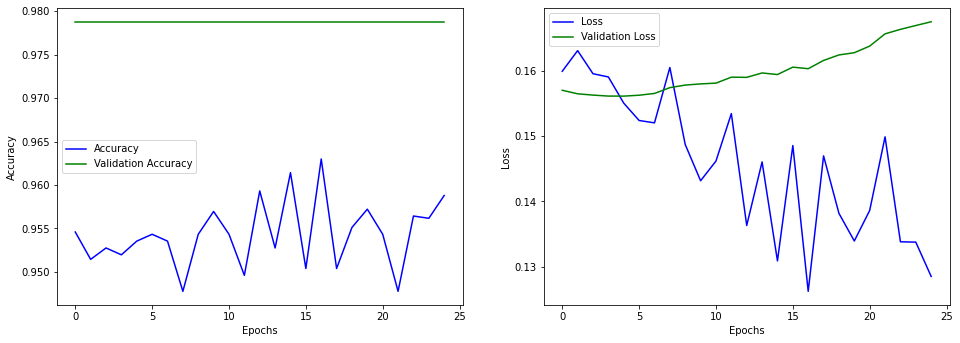

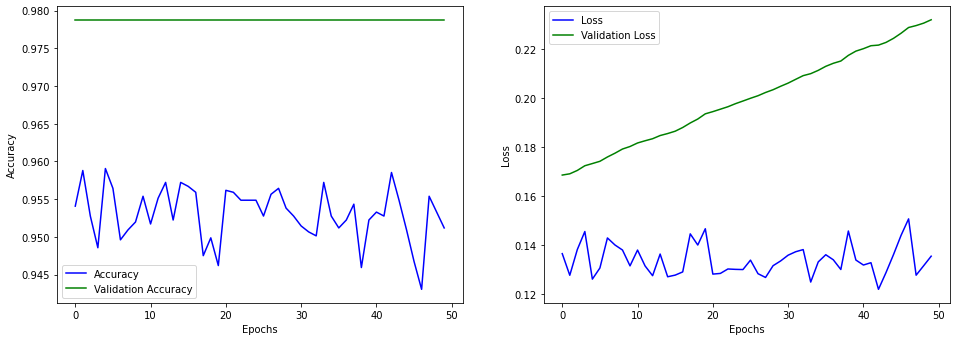

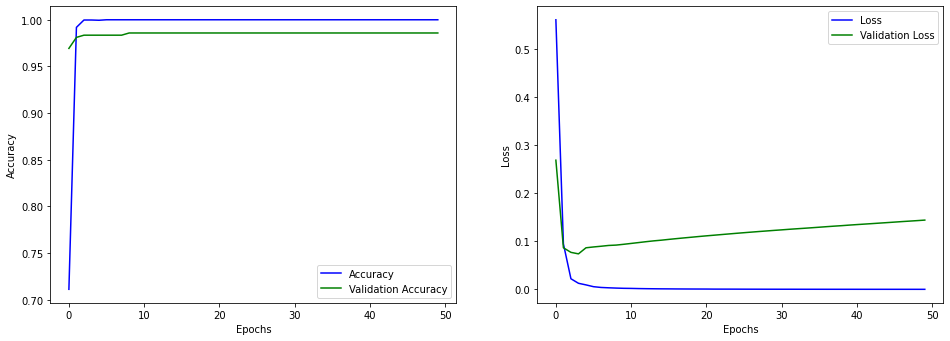

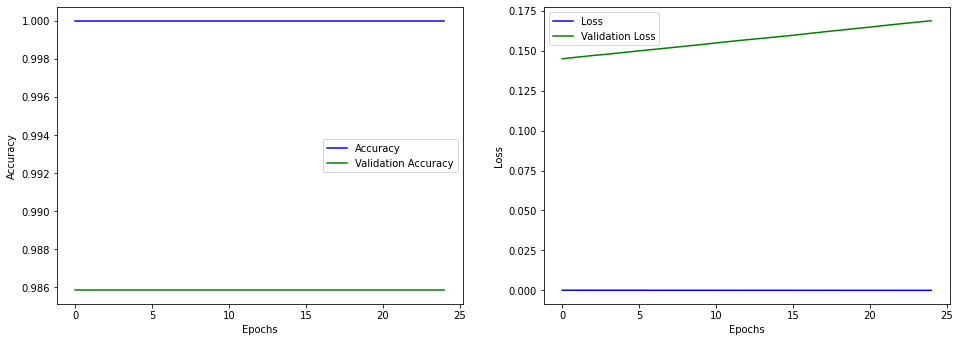

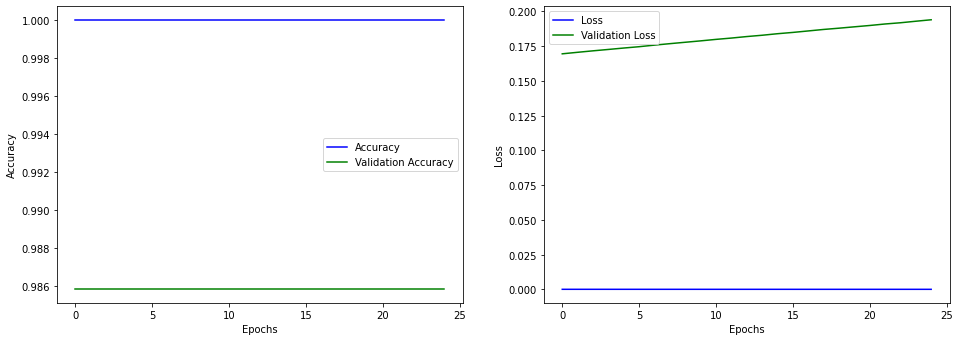

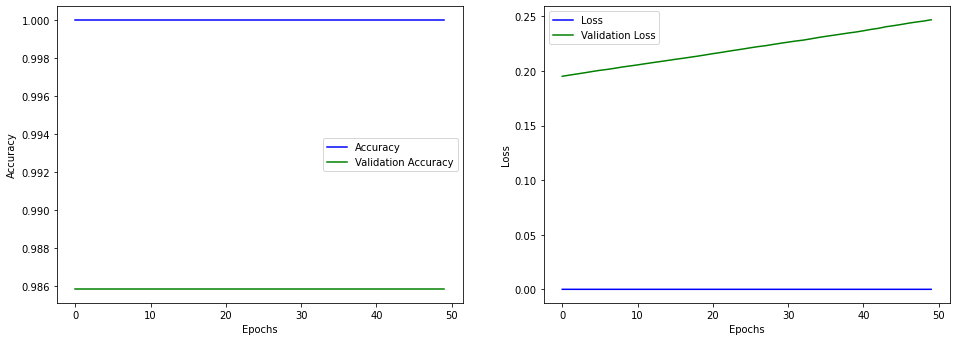

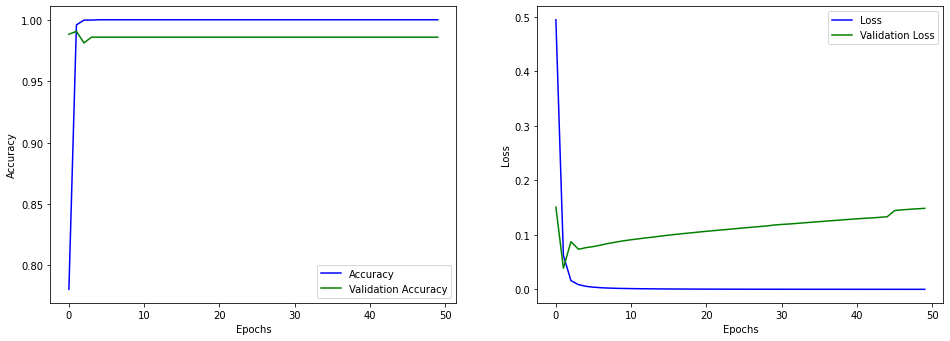

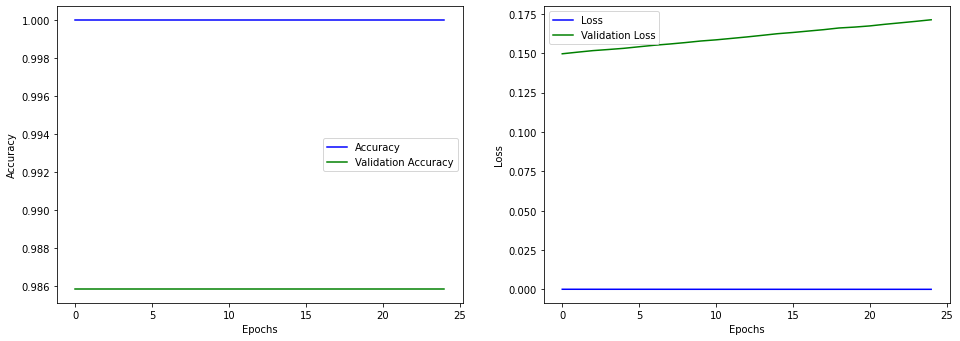

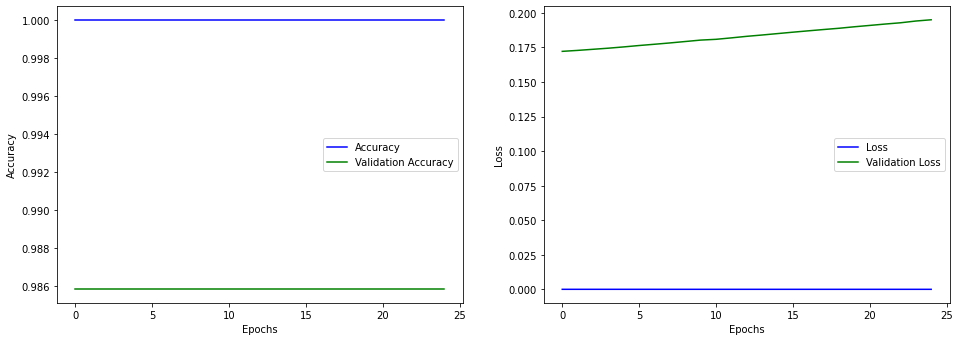

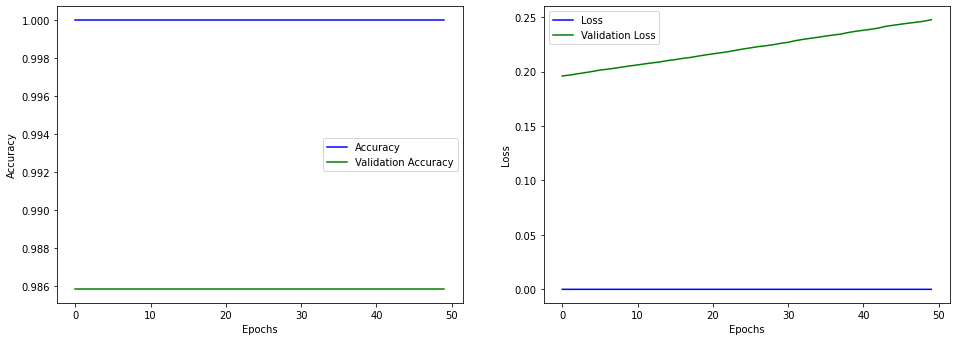

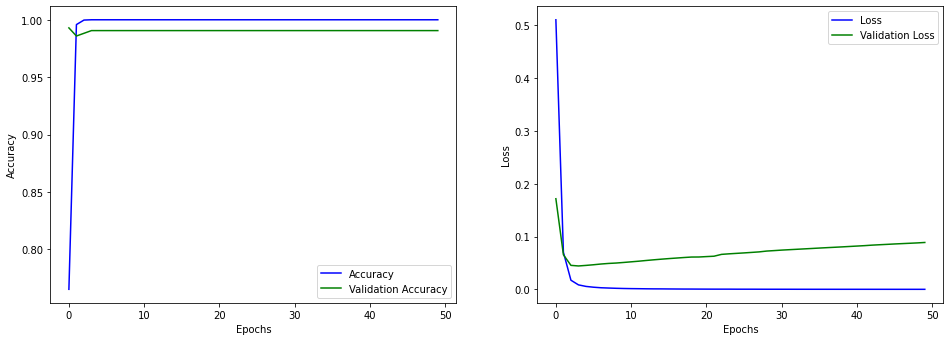

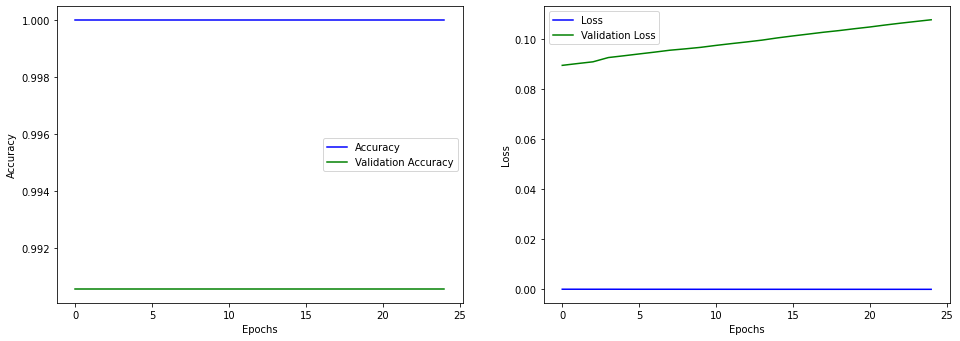

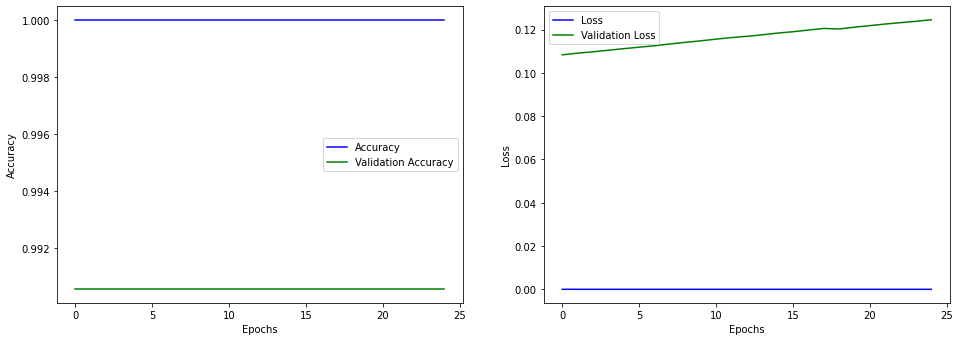

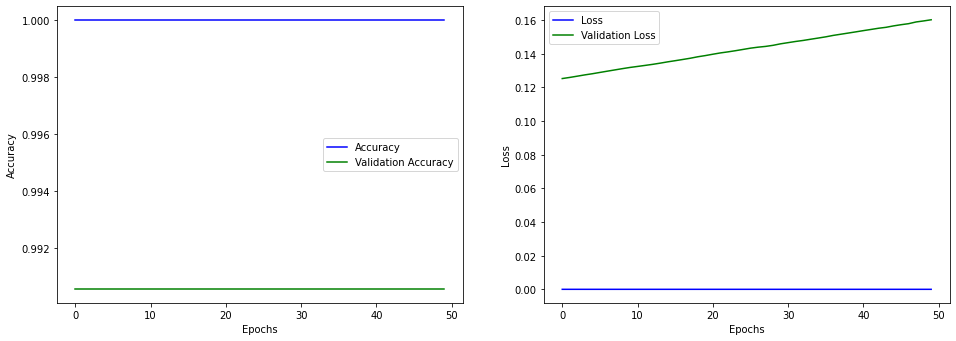

In [ ]:
model_1 = keras.Sequential(
    [
        layers.LSTM(200, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.LSTM(10, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(4, activation='sigmoid', name='layer5'),
        layers.Dense(3, activation='sigmoid', name='layer6'),
        layers.Dense(2, activation='sigmoid', name='layer7'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

model_2 = keras.Sequential(
    [
        layers.LSTM(60, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.LSTM(10, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(4, activation='sigmoid', name='layer5'),
        layers.Dense(3, activation='sigmoid', name='layer6'),
        layers.Dense(2, activation='sigmoid', name='layer7'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

model_3 = keras.Sequential(
    [
        layers.LSTM(60, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(60, activation='sigmoid', name='layer2'),
        layers.LSTM(60, activation='sigmoid', name='layer3'),
        layers.Dense(10, activation='sigmoid', name='layer4'),
        layers.Dense(8, activation='sigmoid', name='layer5'),
        layers.Dense(6, activation='sigmoid', name='layer6'),
        layers.Dense(4, activation='sigmoid', name='layer7'),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

model_4 = keras.Sequential(
    [
        layers.LSTM(60, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(60, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.LSTM(10, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(4, activation='sigmoid', name='layer5'),
        layers.Dense(3, activation='sigmoid', name='layer6'),
        layers.Dense(2, activation='sigmoid', name='layer7'),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

model_5 = keras.Sequential(
    [
        layers.LSTM(5, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input', return_sequences=True),
        layers.Dense(5, activation='relu', name='layer1'),
        layers.Dense(5, activation='sigmoid', name='layer2'),
        layers.LSTM(5, activation='sigmoid', name='layer3'),
        layers.Dense(5, activation='sigmoid', name='layer4'),
        layers.Dense(5, activation='sigmoid', name='layer5'),
        layers.Dense(4, activation='sigmoid', name='layer6'),
        layers.Dense(3, activation='sigmoid', name='layer7'),
        layers.Dense(2, activation='sigmoid', name='layer8'),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

model_6 = keras.Sequential(
    [
        layers.Dense(50, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input'),
        layers.Dense(50, activation='relu', name='layer1'),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.Dense(50, activation='sigmoid', name='layer3'),
        layers.Dense(50, activation='sigmoid', name='layer4'),
        layers.Dense(50, activation='sigmoid', name='layer5'),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

model_7 = keras.Sequential(
    [
        layers.Dense(50, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input'),
        layers.Dense(50, activation='relu', name='layer1'),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.Dense(50, activation='sigmoid', name='layer3'),
        layers.Dense(50, activation='sigmoid', name='layer4'),
        layers.Dense(50, activation='sigmoid', name='layer5'),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

model_8 = keras.Sequential(
    [
        layers.Dense(50, input_shape=(X_train_tfidf_expanded.shape[1:]), activation='relu', name='input'),
        layers.Dense(50, activation='relu', name='layer1'),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(50, activation='sigmoid', name='layer2'),
        layers.Dense(50, activation='sigmoid', name='layer3'),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(50, activation='sigmoid', name='layer4'),
        layers.Dense(50, activation='sigmoid', name='layer5'),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid', name='output')
    ]
)

models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8]
histories = []
results_all = []
#n_epochs = 25
epochs = [50, 25, 25, 50]
batch_size = 32
filenum = 200

for model in models:
  model.compile(loss='binary_crossentropy',optimizer='NAdam',metrics=['accuracy'])

  model.build(input_shape=X_train_tfidf_expanded.shape)

  print(model.summary())

  for n_epochs in epochs:
    checkpoint_path = f'gdrive/My Drive/Colab Data/training_{filenum}/cp.ckpt'
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

    history = model.fit(X_train_tfidf_expanded, t_train_tfidf, epochs=n_epochs, batch_size=batch_size, 
                      validation_split=0.1, verbose=1, callbacks=[cp_callback])
    results = model.evaluate(X_test_tfidf_expanded, t_test_tfidf, batch_size=batch_size)
    print(results)
    histories.append(history)
    results_all.append(results)
    plot_training(history)
    
    model.save(f'gdrive/My Drive/Colab Data/training_{filenum}/model')
    filenum = filenum + 1

Test Loss: 0.1156461089849472
Test Accuracy: 0.9820585250854492
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       783
           1       0.97      0.96      0.97       276

    accuracy                           0.98      1059
   macro avg       0.98      0.97      0.98      1059
weighted avg       0.98      0.98      0.98      1059



Test Loss: 0.09276182949542999
Test Accuracy: 0.9820585250854492
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       783
           1       0.98      0.99      0.98       276

    accuracy                           0.99      1059
   macro avg       0.99      0.99      0.99      1059
weighted avg       0.99      0.99      0.99      1059



Test Loss: 0.10391198843717575
Test Accuracy: 0.9820585250854492
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       783
           1       0.96      0.96      

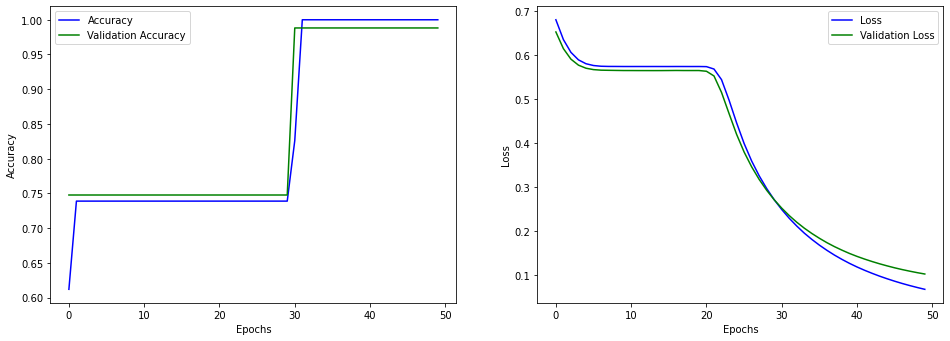

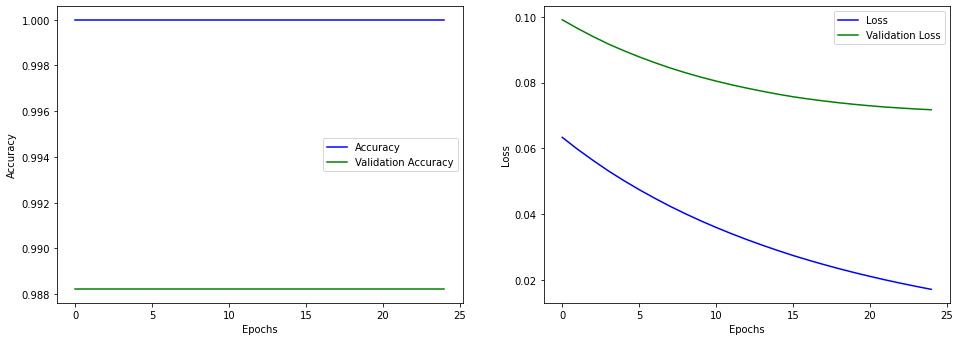

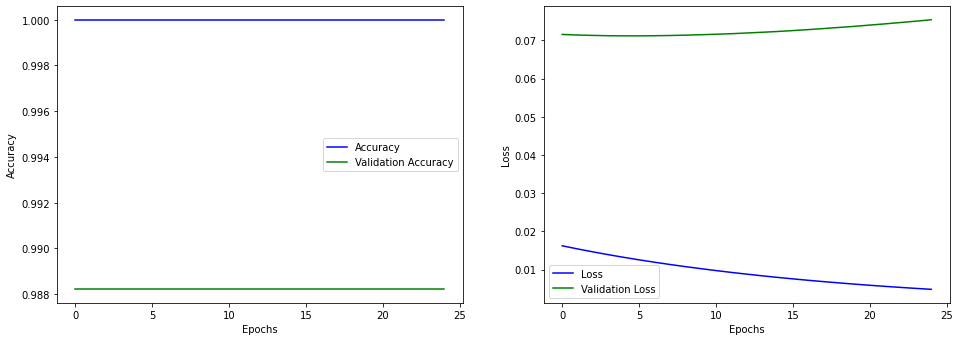

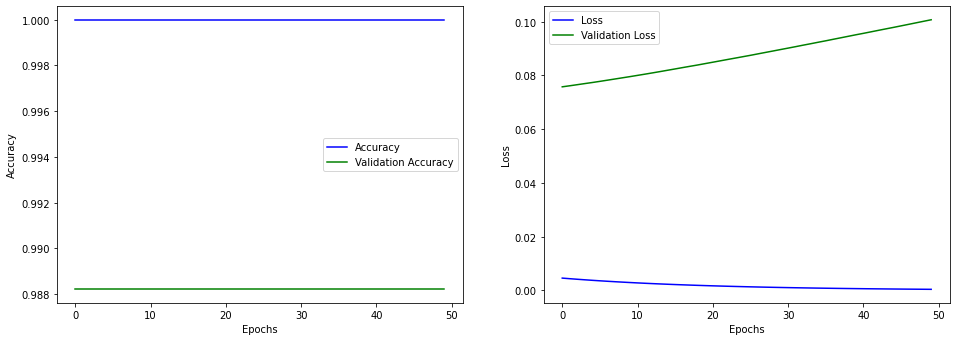

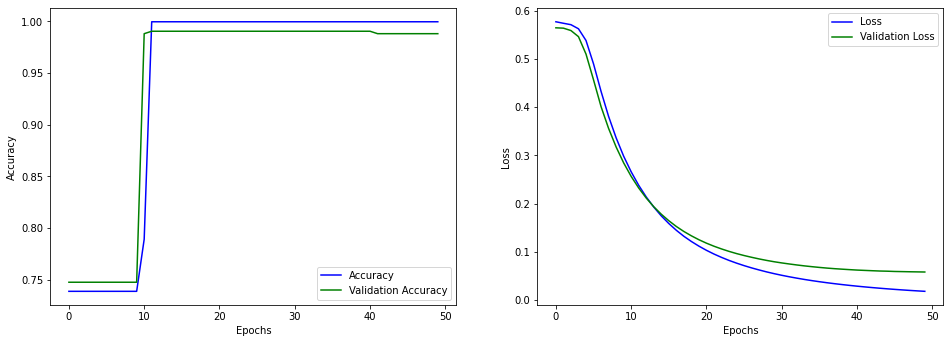

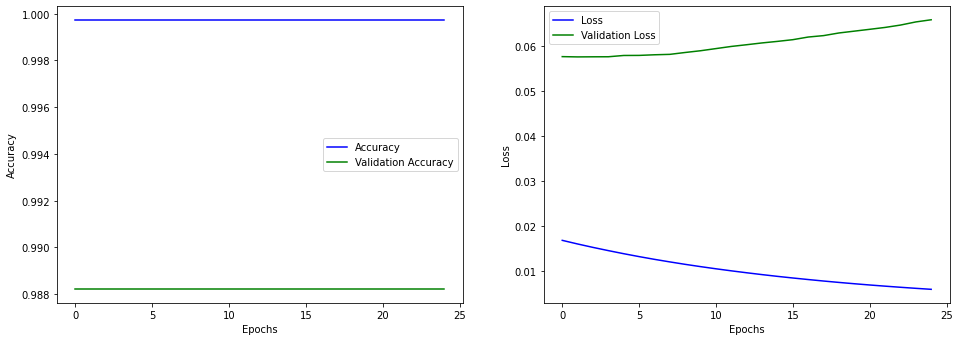

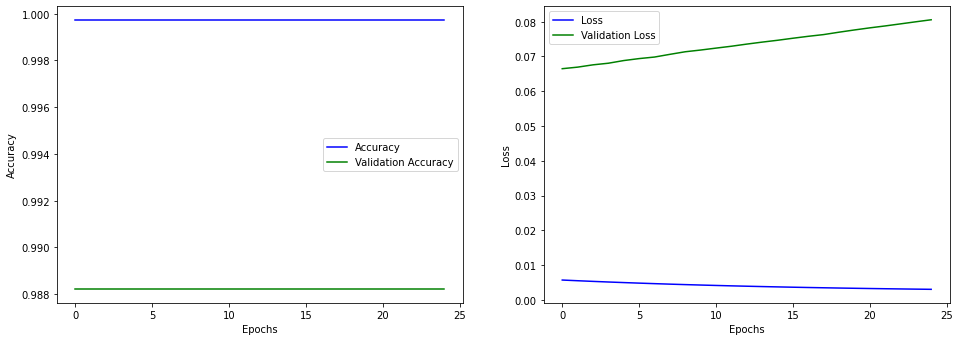

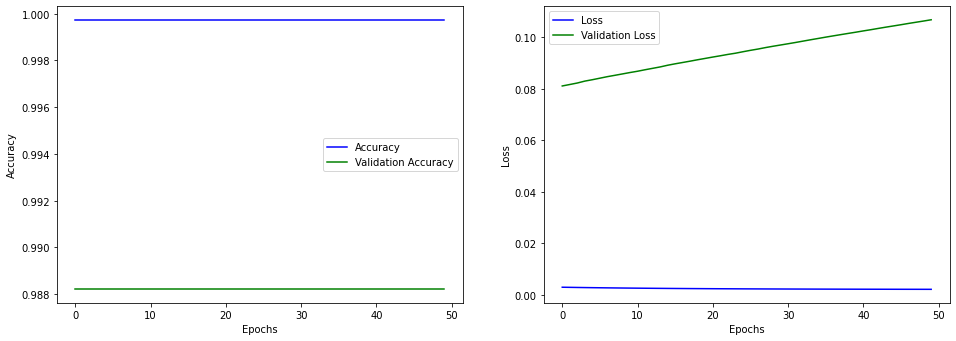

In [ ]:
for m,r,h in zip(models, results_all, histories):
  print(f'Test Loss: {r[0]}')
  print(f'Test Accuracy: {r[1]}')
  plot_training(h)
  pred = m.predict(X_test_tfidf_expanded)
  pred = np.round(pred, 0)
  report = classification_report(t_test_tfidf, pred)
  print(report)
  print('============================================================\n\n')

Test Loss: 0.07112696021795273
Test Accuracy: 0.9915013909339905
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       783
           1       0.99      0.97      0.98       276

    accuracy                           0.99      1059
   macro avg       0.99      0.98      0.99      1059
weighted avg       0.99      0.99      0.99      1059





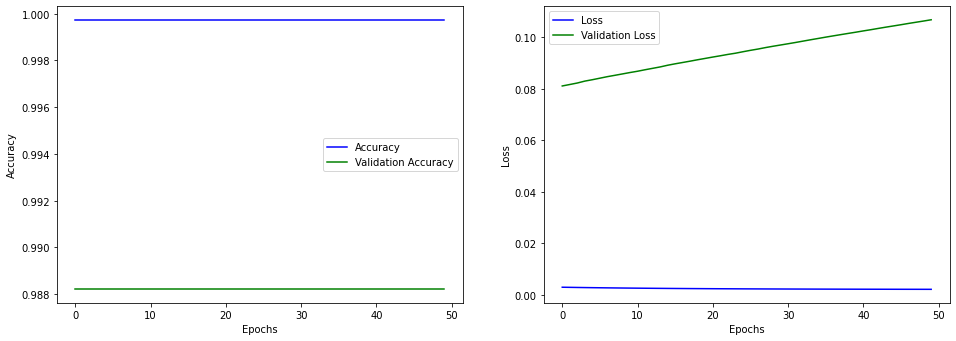

In [ ]:
  print(f'Test Loss: {results_all[7][0]}')
  print(f'Test Accuracy: {results_all[7][1]}')
  plot_training(histories[7])
  pred = models[7].predict(X_test_tfidf_expanded)
  pred = np.round(pred, 0)
  report = classification_report(t_test_tfidf, pred)
  print(report)
  print('============================================================\n\n')

In [ ]:
# Last cell - just disconnect once we're done running everything
#!kill -9 -1